# DTSA 5510 Unsupervised Learning Project: Atrial Fibrillation Cluster Analysis

# Problem Description

Atrial fibrillation (AF) is the most common sustained cardiac arrhythmia and is associated with increased morbidity, including stroke, heart failure, and recurrent hospitalizations. A key challenge in AF management is the heterogeneity in patient presentation, treatment response, and long-term outcomes — particularly the need for redo ablation procedures after initial intervention. Identifying latent patient subgroups that are predisposed to redo procedures may improve personalized management strategies and long-term monitoring.

This problem leverages unsupervised learning techniques to stratify AF patients into clinically meaningful clusters based on a rich set of features including demographics, echocardiographic measurements, HRV indices, ablation history, anticoagulation status, and ECG monitoring findings. Notably, the dataset does not contain predefined patient subtypes or labels, making it an ideal candidate for clustering-based exploration.

---

### Objectives

1. **Clustering AF Patients**  
   Segment patients into distinct subgroups based on their clinical and physiological profiles using unsupervised learning.

2. **Characterizing Cluster Phenotypes**  
   Interpret the clusters by analyzing group differences in age, comorbidities, AF burden, medication use, and ablation history.

3. **Association with Redo Ablation**  
   Determine whether certain clusters are disproportionately associated with redo ablation, and evaluate if cluster membership can serve as a marker of procedural failure or recurrence.

---

This approach aims to uncover latent clinical phenotypes within the AF population and to improve understanding of which subgroups are at higher risk for undergoing redo procedures — ultimately supporting more targeted and interpretable patient care.


Link to the dataset: https://physionet.org/content/shdb-af/1.0.1/

## Description of the Data

This database contains 128 ECG Holter recordings from 93 adult subjects, collected between May 2019 and May 2023. Recorded at 125Hz using Fukuda Holter monitors with modified CC5 and NASA leads, each ~24-hour recording includes a diagnosis from free-text medical reports. Of 145 recordings, 17 were excluded due to duplicates, missing data, or poor signal quality. Ninety-eight recordings were annotated by certified cardiologists, with 80 from subjects with atrial fibrillation (AF). An additional 30 recordings lack rhythm annotations. Per Biton et al. [10], ~100 recordings were re-annotated by a cardiology fellow, stratified by age, sex, and AF diagnosis. Patient data was anonymized per HIPAA, with random 3-digit IDs (000–143) and dates shifted by ≥1 year. ECGs are stored in WFDB format, with two channels: ECG1 (CC5) and ECG2 (NASA).

In [4]:
import pandas as pd
from IPython.display import display

# Define the data as a dictionary where keys are column names and values are descriptions
data = {
    "Column Name": [
        "Subject_ID", "Data_ID", "Annotated", "Height", "Weight", "BMI", 
        "Date_Holter", "Holter_start_time", "Holter_recording_length", 
        "Indication_Holter", "Age_at_Holter", "Sex", "AF_Type", 
        "Previously_Documented_AFL", "Previous_AF_Ablation", 
        "PPM_on_Holter", "PPM_after_Holter", "PPM_Indication", "PPM_Date", 
        "Date_of_First_Diagnosis_of_AF_AFL", "AF_Duration_Months", 
        "Antiarrhythmic_Drug_nonBB", "BB", "Anticoagulation", 
        "Date_of_1st_AF_Ablation", "Ablation1_PVI", "Ablation1_CTI", 
        "Ablation1_Others", "Date_Redo_AF_Ablation", "Redo_Detail", 
        "Echo_Date", "Echo_LAD", "Echo_LVEF", "Echo_LV_Asynergy", 
        "Moderate_or_Severe_MR", "Moderate_or_Severe_TR", 
        "Moderate_or_Severe_AS", "Moderate_or_Severe_AR", 
        "CHF", "HTN", "DM", "Vascular_Diseases", "Stroke", "Comments"
    ],
    "Description": [
        "Unique subject identifier",
        "3-digit Holter recording identifier",
        "Indicates rhythm annotations (Y/N)",
        "Patient height (m)",
        "Patient weight (kg)",
        "Body Mass Index (calculated)",
        "Holter recording date",
        "Recording start time (hh:mm AM/PM)",
        "Recording duration (hh:mm:ss)",
        "Reason for Holter",
        "Subject age (years)",
        "Gender (male/female)",
        "Diagnosis from medical report",
        "Prior atrial flutter (Y/N)",
        "Prior AF ablation (Y/N)",
        "Pacemaker during Holter (Y/N)",
        "Pacemaker after Holter (Y/N)",
        "Pacemaker reason",
        "Pacemaker implantation date",
        "First AF/AFL diagnosis date",
        "AF duration (months)",
        "Medications (non-BB antiarrhythmics)",
        "Medications (Beta-Blockers)",
        "Medications (anticoagulants)",
        "Date of first AF ablation",
        "Pulmonary vein isolation (Y/N)",
        "Cavotricuspid isthmus ablation (Y/N)",
        "Other ablation types",
        "Date of redo AF ablation",
        "Redo ablation details",
        "Echocardiogram date",
        "Left atrial diameter",
        "Left ventricular ejection fraction",
        "Left ventricular asynergy (Y/N)",
        "Mitral Regurgitation (moderate/severe)",
        "Tricuspid Regurgitation (moderate/severe)",
        "Aortic Stenosis (moderate/severe)",
        "Aortic Regurgitation (moderate/severe)",
        "Congestive Heart Failure (Y/N)",
        "Hypertension (Y/N)",
        "Diabetes Mellitus (Y/N)",
        "Vascular Diseases (Y/N)",
        "Prior stroke (Y/N)",
        "Miscellaneous notes"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame with some styling
display(df.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'padding': '5px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold'), ('text-align', 'left')]}
]).set_caption("Holter Database Column Descriptions"))

,Column Name,Description
0,Subject_ID,Unique subject identifier
1,Data_ID,3-digit Holter recording identifier
2,Annotated,Indicates rhythm annotations (Y/N)
3,Height,Patient height (m)
4,Weight,Patient weight (kg)
5,BMI,Body Mass Index (calculated)
6,Date_Holter,Holter recording date
7,Holter_start_time,Recording start time (hh:mm AM/PM)
8,Holter_recording_length,Recording duration (hh:mm:ss)
9,Indication_Holter,Reason for Holter


In [2]:
# Standard Libraries
import os
import sys
import math
import warnings
import contextlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import neurokit2 as nk
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_classif
from sklearn.manifold import TSNE
import scipy.stats as stats
from scipy.stats import pointbiserialr, chi2_contingency
from scipy.stats import entropy as shannon_entropy
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster


## Pre Processing

In [4]:
# Import the data

# Path to the local CSV file
dataset_path = r"C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\AdditionalData.csv"

# Load the CSV into a DataFrame
data = pd.read_csv(dataset_path)

# Preview the dataset
print("Dataset Preview:")
print(data.head())

Dataset Preview:
   Data_ID  Subject_ID  Annotated  Height  Weight   BMI Date_Holter  \
0        1     2043771       True    1.73    63.5  21.2  2021-03-13   
1        2     4980615       True    1.66    55.9  20.3  2021-03-15   
2        3     5379567       True    1.66    63.3  23.0  2021-04-09   
3        4     4369443       True    1.65    53.0  19.5  2021-04-23   
4        5     4899921       True    1.76    98.7  31.9  2021-05-21   

              Indication_Holter  Age_at_Holter Sex  ... Moderate_or_Severe_AR  \
0  AF monitoring after ablation             65   M  ...                   0.0   
1  AF monitoring after ablation             62   M  ...                   0.0   
2                   Palpitation             79   M  ...                   0.0   
3                   Palpitation             76   M  ...                   0.0   
4  AF monitoring after ablation             47   M  ...                   0.0   

   CHF    HTN  Age_75_or_Older     DM Stroke Vascular_Diseases  \
0  

### ECG Data

#### *ECG Feature Extraction*

In [7]:
local_data_dir = r"C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1"

# Shannon entropy helper
def shannon_entropy(prob_dist):
    return -np.sum(prob_dist * np.log2(prob_dist))

# Enhanced ECG feature extraction function
def extract_ecg_features_af_friendly(record_id, data_dir=local_data_dir, max_duration_sec=300, verbose=True):
    try:
        if verbose:
            print(f"\nExtracting AF-compatible ECG features for record {record_id}...")

        # Construct full record path and check if file exists
        record_path = os.path.join(data_dir, record_id)
        if not os.path.exists(record_path + ".dat"):
            raise FileNotFoundError(f"No file found for {record_path}.dat")

        # Load ECG
        record = wfdb.rdrecord(record_path)
        signal = record.p_signal[:, 0]
        fs = record.fs

        # Crop to max duration
        if len(signal) > fs * max_duration_sec:
            signal = signal[:fs * max_duration_sec]

        # Clean ECG
        ecg_cleaned = nk.ecg_clean(signal, sampling_rate=fs)

        # Detect R-peaks
        _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs, correct_artifacts=False)

        if len(rpeaks["ECG_R_Peaks"]) < 3:
            raise ValueError("Too few R-peaks for HRV analysis")

        # HRV time-domain features
        hrv_time = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)

        # Shannon entropy (first 10s or full)
        entropy_signal = ecg_cleaned[:fs * 10] if len(ecg_cleaned) > fs * 10 else ecg_cleaned
        hist, _ = np.histogram(entropy_signal, bins=100, density=True)
        hist = hist[hist > 0]
        shannon = shannon_entropy(hist)
        entropy_df = pd.DataFrame([{"Shannon_Entropy": shannon}])

        # Combine features
        features_df = pd.concat([hrv_time, entropy_df], axis=1)
        features_df["Data_ID"] = int(record_id)

        return features_df

    except Exception as e:
        print(f"Skipped {record_id}: {e}")
        return None

# Extract features for all records
all_features = []

for i in range(1, 144):
    record_id = f"{i:03}"
    result = extract_ecg_features_af_friendly(record_id, verbose=False)
    if result is not None:
        all_features.append(result)

# Combine all features into one DataFrame
if all_features:
    ecg_features_df = pd.concat(all_features, ignore_index=True)
    print("\nECG feature extraction complete.")
    print(ecg_features_df.head())
else:
    print("\nNo ECG features were extracted. Check for file or processing errors.")

Skipped 016: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\016.dat
Skipped 030: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\030.dat
Skipped 044: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\044.dat
Skipped 072: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\072.dat
Skipped 074: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\074.dat
Skipped 075: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\075.dat
Skipped 076: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-

In [8]:
all_features = []

for i in range(1, 144):
    record_id = f"{i:03}"  # formats 1 → "001", 2 → "002", etc.
    result = extract_ecg_features_af_friendly(record_id, verbose=False)
    if result is not None:
        all_features.append(result)

# Combine all into a single DataFrame
ecg_features_df = pd.concat(all_features, ignore_index=True)

# Preview
print(" ECG feature extraction complete.")
print(ecg_features_df.head())


Skipped 016: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\016.dat
Skipped 030: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\030.dat
Skipped 044: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\044.dat
Skipped 072: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\072.dat
Skipped 074: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\074.dat
Skipped 075: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.1\075.dat
Skipped 076: No file found for C:\Users\chris\OneDrive\Desktop\AF_Records\shdb-af-a-japanese-holter-

### Data Cleaning

#### *Check for Missing Data*

In [11]:
# Merge ECG features with original data
data_with_ecg = pd.merge(data, ecg_features_df, on="Data_ID", how="left")



In [12]:
# Count missing values per column
missing_counts = data_with_ecg.isnull().sum()

# Calculate percentage of missing values
missing_percent = 100 * missing_counts / len(data_with_ecg)

# Combine into summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
})

# Show only columns with missing values, sorted by % missing
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
missing_summary = missing_summary.sort_values(by='Missing %', ascending=False)

# Display the summary
print("Missing Data Summary:")
print(missing_summary)


Missing Data Summary:
                                   Missing Count  Missing %
HRV_SDNNI5                                   128     100.00
HRV_SDANN5                                   128     100.00
HRV_SDNNI2                                   128     100.00
HRV_SDANN2                                   128     100.00
Ablation1_Others                             125      97.66
PPM_Indication                               121      94.53
PPM_Date                                     121      94.53
Echo_LV_Asynergy                              99      77.34
Date_Redo_AF_Ablation                         96      75.00
Redo_Detail                                   96      75.00
Antiarrhythmic_Drug_nonBB                     93      72.66
Antiarrhythmic_Drug_BB                        89      69.53
Date_1st_AF_Ablation                          67      52.34
Ablation1_PVI                                 64      50.00
Ablation1_CTI                                 64      50.00
Anticoagulation   

#### *Handle the Missing Data and Assign Binary Values*

In [16]:
# Drop Unnecessary Columns and
drop_columns_initial = [
    "HRV_SDNNI5", "HRV_SDANN5", "HRV_SDNNI2", "HRV_SDANN2", "HRV_SDANN1", "HRV_SDNNI1",
    "Echo_Date", "Subject_ID", "Date_of_First_Diagnosis_of_AF_AFL", "Date_Holter", "Annotated", "PPM_Date",
    "Ablation1_Others", "PPM_Indication", "Date_Redo_AF_Ablation", "Date_1st_AF_Ablation"
]
data_with_ecg = data_with_ecg.drop(columns=drop_columns_initial, errors='ignore')

# Impute Missing Values
impute_zero = [
    "Moderate_or_Severe_MR", "Moderate_or_Severe_TR", "Moderate_or_Severe_AS", 
    "Moderate_or_Severe_AR", "CHF", "Antiarrhythmic_Drug_nonBB", 
    "Antiarrhythmic_Drug_BB", "Ablation1_PVI", "Ablation1_CTI", "Anticoagulation", 
    "AF_Duration_Months"
]
data_with_ecg[impute_zero] = data_with_ecg[impute_zero].fillna(0)

impute_mean = ["Weight", "BMI", "Height", "Echo_LAD", "Echo_LVEF"]
for col in impute_mean:
    if col in data_with_ecg.columns:
        data_with_ecg[col] = data_with_ecg[col].fillna(data_with_ecg[col].mean())

# Encode 'Sex' Column
data_with_ecg['Sex'] = data_with_ecg['Sex'].map({'M': 1, 'F': 0})

# One-Hot Encode Indication_Holter
if 'Indication_Holter' in data_with_ecg.columns:
    for val in data_with_ecg['Indication_Holter'].dropna().unique():
        col_name = f"Holter_{val}".replace(" ", "_").replace("/", "_").replace("-", "_")
        data_with_ecg[col_name] = (data_with_ecg['Indication_Holter'] == val).astype(int)
    data_with_ecg = data_with_ecg.drop(columns=['Indication_Holter'])

# One-Hot Encode AF_Type
data_with_ecg['AF_Type_PAF'] = (data_with_ecg['AF_Type'] == 'PAF').astype(int)
data_with_ecg['AF_Type_PerAF'] = (data_with_ecg['AF_Type'] == 'PerAF').astype(int)
data_with_ecg['AF_Type_non_AF'] = (data_with_ecg['AF_Type'] == 'non-AF').astype(int)
data_with_ecg.drop(columns=['AF_Type'], inplace=True)

# One-Hot Encode Drug Columns and Create Drug Class Flags
drug_columns = ['Antiarrhythmic_Drug_nonBB', 'Antiarrhythmic_Drug_BB', 'Anticoagulation']
for col in drug_columns:
    dummies = pd.get_dummies(data_with_ecg[col], prefix=col)
    dummies.drop(columns=[f"{col}_0"], errors='ignore', inplace=True)
    data_with_ecg = pd.concat([data_with_ecg, dummies], axis=1)

data_with_ecg['Is_NOAC'] = data_with_ecg[[f'Anticoagulation_{d}' for d in ['edoxaban', 'apixaban', 'rivaroxaban', 'dabigatran'] if f'Anticoagulation_{d}' in data_with_ecg.columns]].sum(axis=1).clip(upper=1)
data_with_ecg['Is_Class_I'] = data_with_ecg[[f'Antiarrhythmic_Drug_nonBB_{d}' for d in ['flecainide', 'pilsicainide', 'cibenzoline', 'aprindine'] if f'Antiarrhythmic_Drug_nonBB_{d}' in data_with_ecg.columns]].sum(axis=1).clip(upper=1)
data_with_ecg['Is_Class_III'] = data_with_ecg[[f'Antiarrhythmic_Drug_nonBB_{d}' for d in ['amiodarone', 'bepridil'] if f'Antiarrhythmic_Drug_nonBB_{d}' in data_with_ecg.columns]].sum(axis=1).clip(upper=1)
data_with_ecg['Is_CCB'] = data_with_ecg[[f'Antiarrhythmic_Drug_nonBB_{d}' for d in ['verapamil'] if f'Antiarrhythmic_Drug_nonBB_{d}' in data_with_ecg.columns]].sum(axis=1).clip(upper=1)
data_with_ecg['Is_BetaBlocker'] = data_with_ecg[[f'Antiarrhythmic_Drug_BB_{d}' for d in ['bisoprolol', 'carvedilol', 'metoprolol'] if f'Antiarrhythmic_Drug_BB_{d}' in data_with_ecg.columns]].sum(axis=1).clip(upper=1)

# One-Hot Encode LV Asynergy
data_with_ecg['Echo_LV_Asynergy'] = (
    data_with_ecg['Echo_LV_Asynergy']
    .str.lower()
    .str.strip()
    .replace({
        'anteroseptal': 'anterior_group', 'anterosept': 'anterior_group',
        'anterosep': 'anterior_group', 'anterior': 'anterior_group',
        'diffuse hypokinesis': 'diffuse', 'nnoe': 'none', '': 'none'
    })
    .fillna('none')
)
asynergy_dummies = pd.get_dummies(data_with_ecg['Echo_LV_Asynergy'], prefix='Asynergy')
data_with_ecg = pd.concat([data_with_ecg, asynergy_dummies], axis=1)
asynergy_cols = [col for col in data_with_ecg.columns if col.startswith('Asynergy_')]
data_with_ecg[asynergy_cols] = data_with_ecg[asynergy_cols].astype(int)

# Extract Binary Flags from Comments
comment_keywords = {
    'Has_PPM': ['ppm'], 'Has_SSS': ['sss'], 'Has_Stroke': ['stroke'],
    'Has_ESRD': ['esrd', 'hemodialysis', 'hd'],
    'Has_AF_on_Holter': ['af detected', 'af on holter', 'short af'],
    'Has_Malignancy': ['cancer', 'colorectal', 'lung resection'],
    'Has_MI': ['old mi', 'myocardial infarction', 'vf in acute phase'],
    'Has_ICD': ['icd', 'vvi'], 'Has_Ablation': ['ablation', 'pvi'],
    'Has_Brugada': ['brugada'], 'Has_Aortic_Dissect': ['aortic dissection']
}
data_with_ecg['Comments_clean'] = data_with_ecg['Comments'].astype(str).str.lower()
for col, keywords in comment_keywords.items():
    data_with_ecg[col] = data_with_ecg['Comments_clean'].apply(lambda x: int(any(k in x for k in keywords)))
data_with_ecg = data_with_ecg.drop(columns=['Comments', 'Comments_clean'], errors='ignore')

# Encode Redo_Detail Procedures
data_with_ecg['Redo_Detail_clean'] = data_with_ecg['Redo_Detail'].astype(str).str.lower().str.strip()
for proc in ['re-pvi', 'cti', 'svci', 'pwi', 'non-pv', 'at ablation']:
    col_name = f"Redo_{proc.replace('-', '_')}"
    data_with_ecg[col_name] = data_with_ecg['Redo_Detail_clean'].apply(lambda x: int(proc in x))
data_with_ecg.drop(columns=['Redo_Detail', 'Redo_Detail_clean'], errors='ignore', inplace=True)

# Final Cleanup: Convert all boolean columns to integers
bool_cols = data_with_ecg.select_dtypes(include='bool').columns
data_with_ecg[bool_cols] = data_with_ecg[bool_cols].astype(int)


In [17]:
# Count missing values per column
missing_counts = data_with_ecg.isnull().sum()

# Calculate percentage of missing values
missing_percent = 100 * missing_counts / len(data_with_ecg)

# Combine into summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
})

# Filter to only show columns with missing values
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
missing_summary = missing_summary.sort_values(by='Missing %', ascending=False)

# Display the summary
print("Missing Data Summary After Cleaning:")
print(missing_summary)


Missing Data Summary After Cleaning:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


The ECG features have been extracted, missing data has been handled, and binary categorical data has been set. 

In [19]:
# Identify all columns that start with 'Redo'
redo_columns = [col for col in data_with_ecg.columns if col.startswith('Redo')]

# Create and append the new column 'Redo_Ablation'
data_with_ecg['Redo_Ablation'] = data_with_ecg[redo_columns].sum(axis=1).clip(upper=1)



## Exploratory Data Analysis

In [21]:

continuous = [
    "Height", "Weight", "BMI", "Age_at_Holter", "AF_Duration_Months", "Echo_LAD", "Echo_LVEF",
    "HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_SDSD", "HRV_CVNN", "HRV_CVSD", "HRV_MedianNN",
    "HRV_MadNN", "HRV_MCVNN", "HRV_IQRNN", "HRV_Prc20NN", "HRV_Prc80NN", "HRV_pNN50", "HRV_pNN20",
    "HRV_MinNN", "HRV_MaxNN", "HRV_HTI", "HRV_TINN", "Shannon_Entropy"
]
categorical = [
    "Sex", "Previously_Documented_AFL", "Previous_AF_Ablation", "PPM_on_Holter", "PPM_after_Holter",
    "Antiarrhythmic_Drug_nonBB", "Antiarrhythmic_Drug_BB", "Anticoagulation", "Ablation1_PVI", "Ablation1_CTI",
    "Echo_LV_Asynergy", "Moderate_or_Severe_MR", "Moderate_or_Severe_TR", "Moderate_or_Severe_AS",
    "Moderate_or_Severe_AR", "CHF", "HTN", "Age_75_or_Older", "DM", "Stroke", "Vascular_Diseases",
    "Holter_AF_monitoring_after_ablation", "Holter_Palpitation", "Holter_Syncope", "Holter_VA_monitoring",
    "Holter_AF_monitoring_without_ablation", "Holter_Bradycardia", "Holter_Others", "Holter_Angina", "Holter_ESUS",
    "AF_Type_PAF", "AF_Type_PerAF", "AF_Type_non_AF", "Antiarrhythmic_Drug_nonBB_amiodarone",
    "Antiarrhythmic_Drug_nonBB_aprindine", "Antiarrhythmic_Drug_nonBB_bepridil", "Antiarrhythmic_Drug_nonBB_cibenzoline",
    "Antiarrhythmic_Drug_nonBB_frecainide", "Antiarrhythmic_Drug_nonBB_pilsicainide",
    "Antiarrhythmic_Drug_nonBB_verapamil", "Antiarrhythmic_Drug_BB_bisoprolol", "Antiarrhythmic_Drug_BB_carvedilol",
    "Antiarrhythmic_Drug_BB_metoprolol", "Anticoagulation_apixaban", "Anticoagulation_dabigatran",
    "Anticoagulation_edoxaban", "Anticoagulation_rivaroxaban", "Anticoagulation_warfarin", "Is_NOAC",
    "Is_Class_I", "Is_Class_III", "Is_CCB", "Is_BetaBlocker", "Asynergy_anterior_group", "Asynergy_apical",
    "Asynergy_diffuse", "Asynergy_inferior", "Asynergy_none", "Asynergy_septal", "Has_PPM", "Has_SSS",
    "Has_Stroke", "Has_ESRD", "Has_AF_on_Holter", "Has_Malignancy", "Has_MI", "Has_ICD", "Has_Ablation",
    "Has_Brugada", "Has_Aortic_Dissect", "Redo_Ablation"
]
null = [
    "Data_ID", "Holter_start_time", "Holter_recording_length"
]


In [22]:
print("Summary Statistics for Continuous Variables:")
print(data_with_ecg[continuous].describe())


Summary Statistics for Continuous Variables:
           Height      Weight         BMI  Age_at_Holter  AF_Duration_Months  \
count  128.000000  128.000000  128.000000     128.000000          128.000000   
mean     1.642984   62.446774   22.996774      65.789062           11.070312   
std      0.084890   13.689955    4.020047      12.061295           23.303943   
min      1.450000   35.900000   14.400000      29.000000            0.000000   
25%      1.590000   54.075000   20.450000      60.000000            0.000000   
50%      1.642984   61.050000   22.700000      67.500000            0.000000   
75%      1.702500   68.825000   24.725000      74.250000           10.250000   
max      1.850000  112.600000   39.400000      87.000000          143.000000   

         Echo_LAD   Echo_LVEF   HRV_MeanNN     HRV_SDNN    HRV_RMSSD  ...  \
count  128.000000  128.000000   128.000000   128.000000   128.000000  ...   
mean    39.608000   63.200000   765.706030   103.984340   111.200598  ...   
std

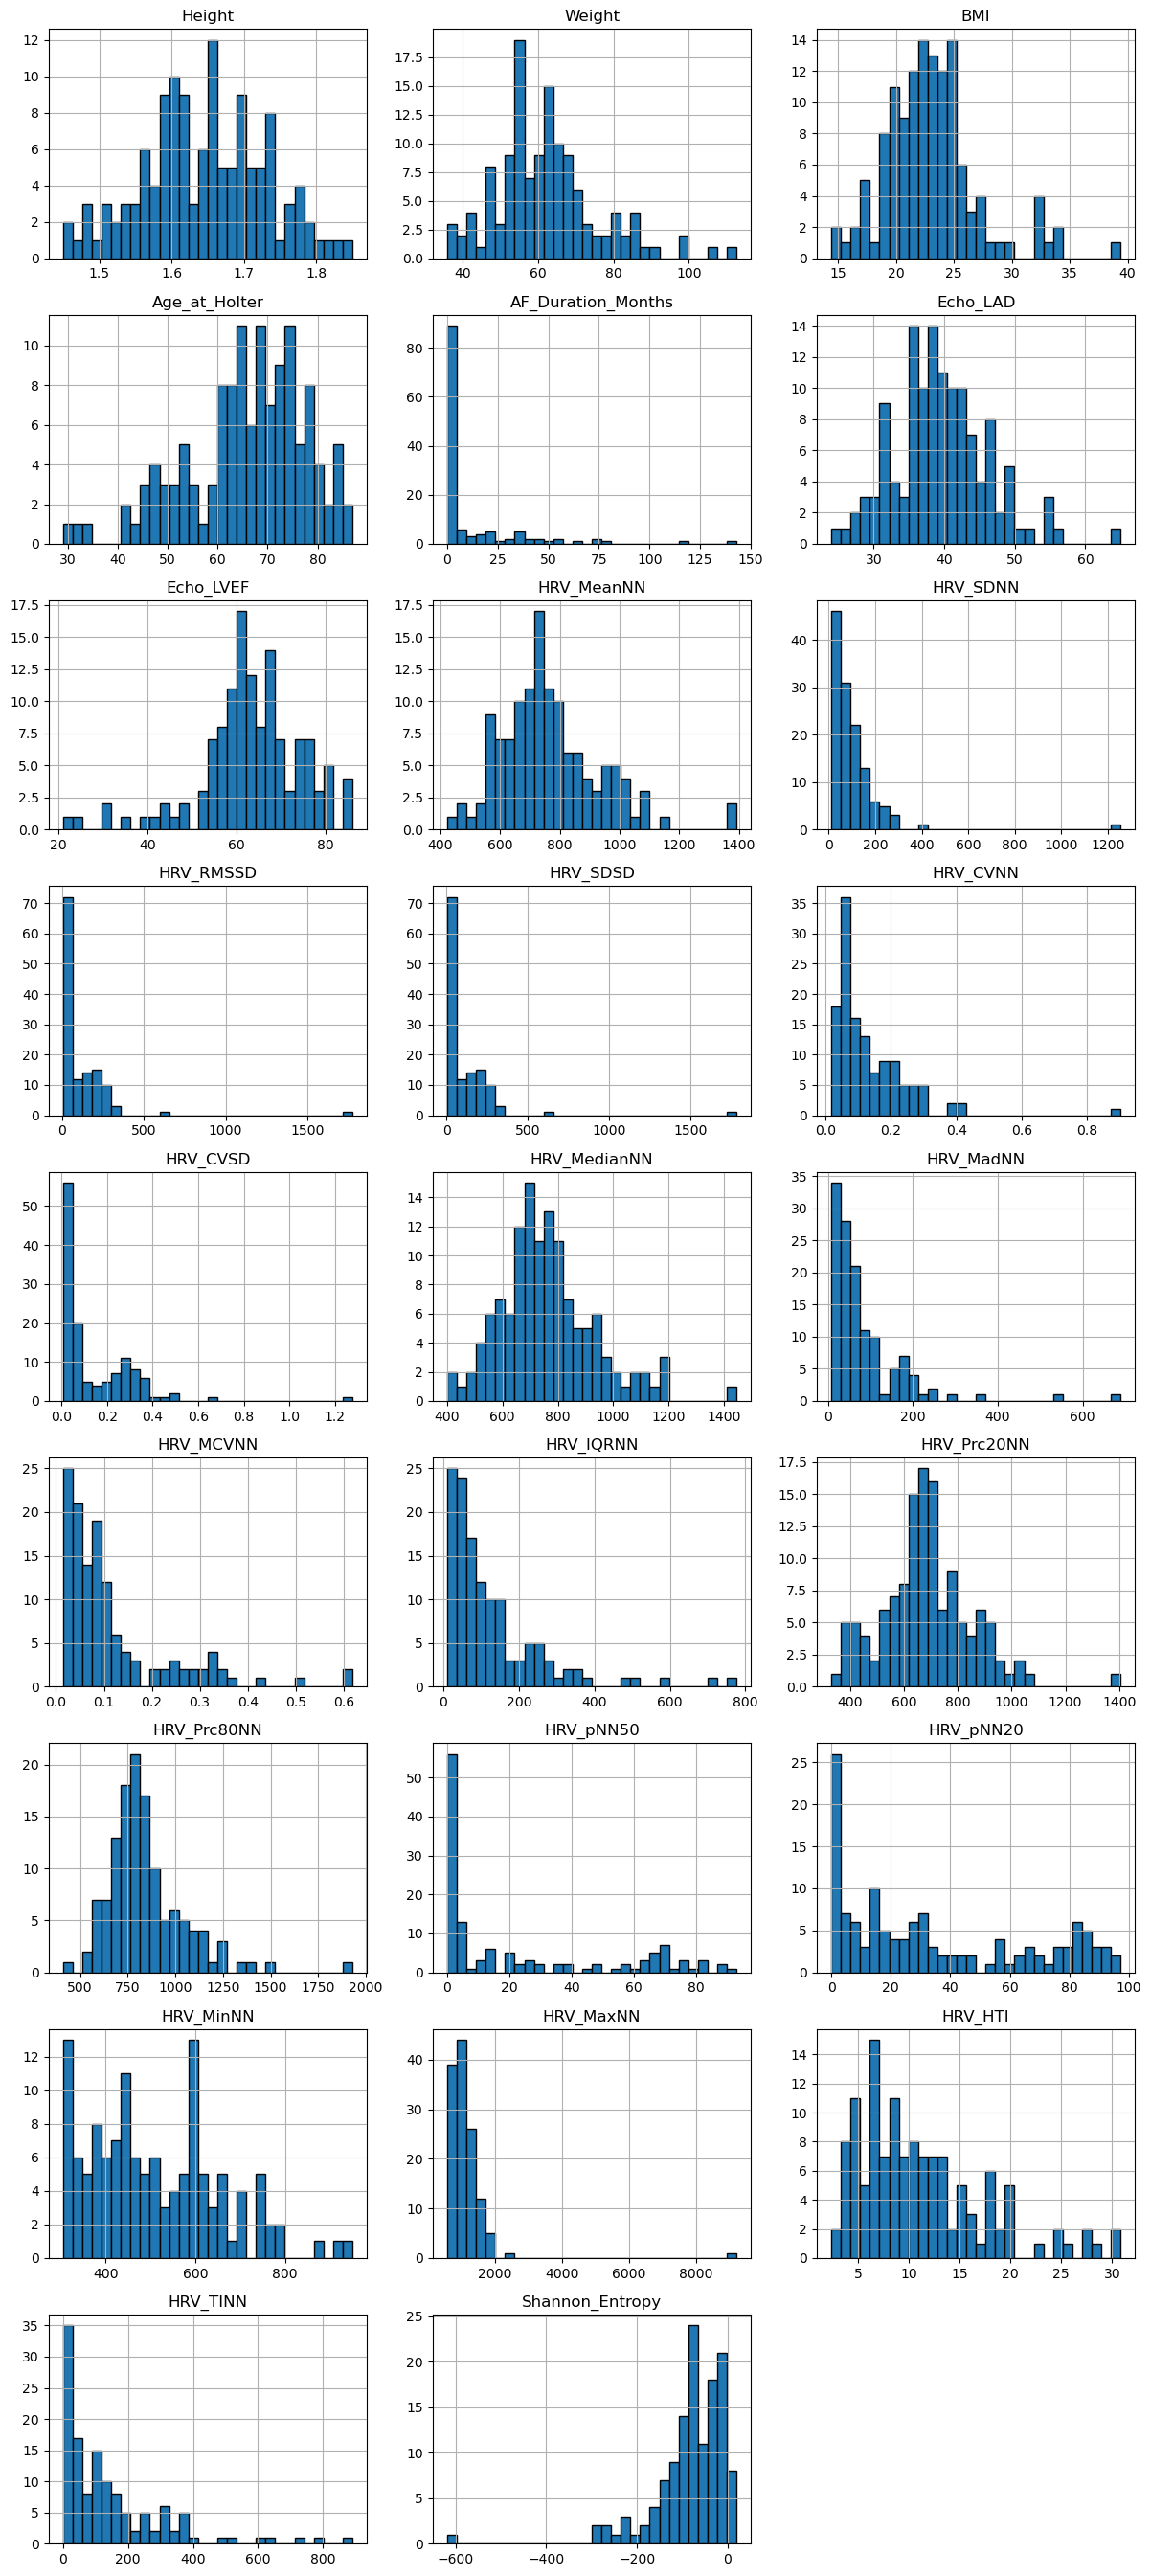

In [23]:
# Settings
cols_per_row = 3
num_vars = len(continuous)
num_rows = math.ceil(num_vars / cols_per_row)

# Create subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 4, num_rows * 3))
axes = axes.flatten()  

for idx, col in enumerate(continuous):
    ax = axes[idx]
    data_with_ecg[col].hist(ax=ax, bins=30, edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Hide unused axes if any
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [24]:
summary = []

for col in categorical:
    counts = data_with_ecg[col].value_counts(dropna=False).to_dict()
    for val, count in counts.items():
        summary.append({
            "Variable": col,
            "Value": val,
            "Count": count
        })

summary_df = pd.DataFrame(summary)
display(summary_df)


,Variable,Value,Count
0,Sex,1,81
1,Sex,0,47
2,Previously_Documented_AFL,0,111
3,Previously_Documented_AFL,1,17
4,Previous_AF_Ablation,0,87
...,...,...,...
152,Has_Brugada,1,2
153,Has_Aortic_Dissect,0,126
154,Has_Aortic_Dissect,1,2
155,Redo_Ablation,0,96


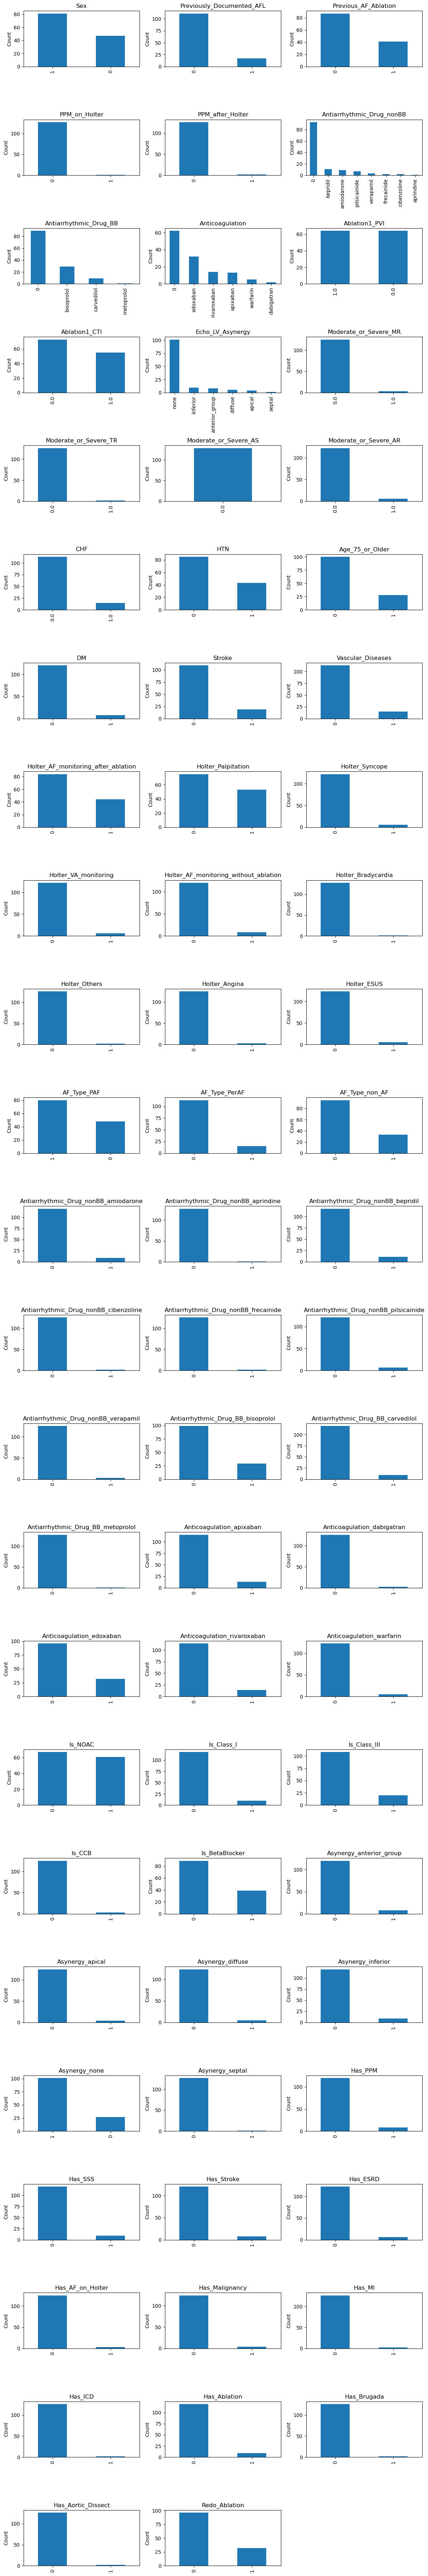

In [25]:
# Settings
cols_per_row = 3
num_vars = len(categorical)
num_rows = math.ceil(num_vars / cols_per_row)

# Create subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 4, num_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(categorical):
    ax = axes[idx]
    data_with_ecg[col].value_counts(dropna=False).plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Count")

# Hide unused axes
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [26]:
summary_tables = []

for col in categorical:
    if col != "Redo_Ablation":
        crosstab = pd.crosstab(data_with_ecg[col], data_with_ecg["Redo_Ablation"], margins=True)
        crosstab.columns = [f"{col}_Redo_{val}" for val in crosstab.columns]
        summary_tables.append(crosstab.T)  

# Concatenate all crosstabs horizontally
summary_df = pd.concat(summary_tables, axis=1)
display(summary_df)

,0,1,All,0,1,All,0,1,All,0,...,All,0,1,All,0,1,All,0,1,All
Sex_Redo_0,39.0,57.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex_Redo_1,8.0,24.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex_Redo_All,47.0,81.0,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Previously_Documented_AFL_Redo_0,NaN,NaN,NaN,88.0,8.0,96.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Previously_Documented_AFL_Redo_1,NaN,NaN,NaN,23.0,9.0,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Has_Brugada_Redo_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,32.0,0.0,32.0,NaN,NaN,NaN
Has_Brugada_Redo_All,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,126.0,2.0,128.0,NaN,NaN,NaN
Has_Aortic_Dissect_Redo_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,2.0,96.0
Has_Aortic_Dissect_Redo_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,0.0,32.0


In [27]:
summary_rows = []

for col in categorical:
    if col != "Redo_Ablation":
        ctab = pd.crosstab(data_with_ecg[col], data_with_ecg["Redo_Ablation"])
        if 1 in ctab.columns and ctab[1].sum() > 0:
            for idx in ctab.index:
                summary_rows.append({
                    "Variable": col,
                    "Category": idx,
                    "Redo_0": ctab.loc[idx, 0] if 0 in ctab.columns else 0,
                    "Redo_1": ctab.loc[idx, 1],
                    "Total": ctab.loc[idx].sum()
                })

condensed_ctabs_df = pd.DataFrame(summary_rows)
display(condensed_ctabs_df)


,Variable,Category,Redo_0,Redo_1,Total
0,Sex,0,39,8,47
1,Sex,1,57,24,81
2,Previously_Documented_AFL,0,88,23,111
3,Previously_Documented_AFL,1,8,9,17
4,Previous_AF_Ablation,0,81,6,87
...,...,...,...,...,...
150,Has_Ablation,1,8,1,9
151,Has_Brugada,0,94,32,126
152,Has_Brugada,1,2,0,2
153,Has_Aortic_Dissect,0,94,32,126


In [28]:


print("Chi-squared p-values for categorical variables vs Redo_Ablation:\n")
for col in categorical:
    if col != "Redo_Ablation":
        table = pd.crosstab(data_with_ecg[col], data_with_ecg["Redo_Ablation"])
        if table.shape == (2, 2):  # only apply to 2x2 tables
            _, p, _, _ = chi2_contingency(table)
            print(f"{col}: p = {p:.4f}")


Chi-squared p-values for categorical variables vs Redo_Ablation:

Sex: p = 0.1687
Previously_Documented_AFL: p = 0.0106
Previous_AF_Ablation: p = 0.0000
PPM_on_Holter: p = 1.0000
PPM_after_Holter: p = 1.0000
Ablation1_PVI: p = 0.0000
Ablation1_CTI: p = 0.0000
Moderate_or_Severe_MR: p = 0.7359
Moderate_or_Severe_TR: p = 1.0000
Moderate_or_Severe_AR: p = 1.0000
CHF: p = 0.8739
HTN: p = 1.0000
Age_75_or_Older: p = 0.0840
DM: p = 0.2059
Stroke: p = 0.4730
Vascular_Diseases: p = 0.0392
Holter_AF_monitoring_after_ablation: p = 0.0000
Holter_Palpitation: p = 0.0003
Holter_Syncope: p = 1.0000
Holter_VA_monitoring: p = 0.3342
Holter_AF_monitoring_without_ablation: p = 0.2059
Holter_Bradycardia: p = 1.0000
Holter_Others: p = 1.0000
Holter_Angina: p = 0.7359
Holter_ESUS: p = 0.4294
AF_Type_PAF: p = 0.1400
AF_Type_PerAF: p = 0.0173
AF_Type_non_AF: p = 0.0003
Antiarrhythmic_Drug_nonBB_amiodarone: p = 0.3183
Antiarrhythmic_Drug_nonBB_aprindine: p = 1.0000
Antiarrhythmic_Drug_nonBB_bepridil: p = 0.00

In [29]:
SigCategorical = [
    "Previously_Documented_AFL",
    "Previous_AF_Ablation",
    "Ablation1_PVI",
    "Ablation1_CTI",
    "Vascular_Diseases",
    "Holter_AF_monitoring_after_ablation",
    "Holter_Palpitation",
    "AF_Type_PerAF",
    "AF_Type_non_AF",
    "Antiarrhythmic_Drug_nonBB_bepridil",
    "Antiarrhythmic_Drug_BB_bisoprolol",
    "Anticoagulation_apixaban",
    "Anticoagulation_edoxaban",
    "Is_NOAC",
    "Is_Class_III",
    "Is_BetaBlocker"
]


In [30]:
correlation_results = []

for var in SigCategorical:
    if data_with_ecg[var].nunique() == 2:
        corr, pval = pointbiserialr(data_with_ecg[var], data_with_ecg['Redo_Ablation'])
        correlation_results.append({
            "Variable": var,
            "Correlation": round(corr, 4),
            "R^2": round(corr ** 2, 4),
            "p-value": round(pval, 4)
        })

# Display the results
import pandas as pd
pd.DataFrame(correlation_results)

,Variable,Correlation,R^2,p-value
0,Previously_Documented_AFL,0.2525,0.0638,0.0040
1,Previous_AF_Ablation,0.6090,0.3709,0.0000
2,Ablation1_PVI,0.5774,0.3333,0.0000
3,Ablation1_CTI,0.4829,0.2332,0.0000
4,Vascular_Diseases,-0.2104,0.0442,0.0172
5,Holter_AF_monitoring_after_ablation,0.6078,0.3694,0.0000
6,Holter_Palpitation,-0.3388,0.1148,0.0001
7,AF_Type_PerAF,0.2384,0.0568,0.0067
8,AF_Type_non_AF,-0.3403,0.1158,0.0001
9,Antiarrhythmic_Drug_nonBB_bepridil,0.2736,0.0749,0.0018


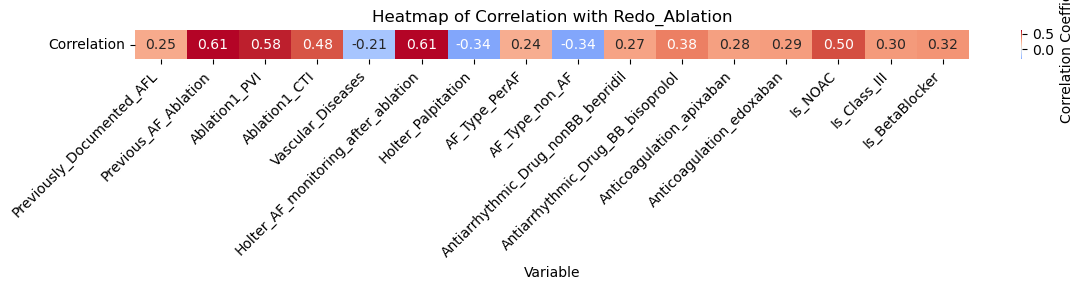

In [31]:
correlation_data = pd.DataFrame({
    "Variable": [
        "Previously_Documented_AFL", "Previous_AF_Ablation", "Ablation1_PVI", "Ablation1_CTI", "Vascular_Diseases",
        "Holter_AF_monitoring_after_ablation", "Holter_Palpitation", "AF_Type_PerAF", "AF_Type_non_AF",
        "Antiarrhythmic_Drug_nonBB_bepridil", "Antiarrhythmic_Drug_BB_bisoprolol", "Anticoagulation_apixaban",
        "Anticoagulation_edoxaban", "Is_NOAC", "Is_Class_III", "Is_BetaBlocker"
    ],
    "Correlation": [
        0.2525, 0.6090, 0.5774, 0.4829, -0.2104, 0.6078, -0.3388, 0.2384, -0.3403,
        0.2736, 0.3771, 0.2837, 0.2917, 0.4967, 0.2981, 0.3234
    ]
})

# Create a heatmap
plt.figure(figsize=(12, 3))  # Adjust height for a horizontal layout
heatmap_data = correlation_data.set_index("Variable").T
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'}
)

# Rotate x-axis labels and adjust alignment
plt.xticks(rotation=45, ha='right')  # Rotate and right-align
plt.yticks(rotation=0)
plt.title("Heatmap of Correlation with Redo_Ablation")
plt.tight_layout()
plt.show()



The correlation analysis revealed several categorical variables with significant associations to the outcome variable, Redo_Ablation. The most strongly correlated variables were Previous_AF_Ablation (r = 0.6090, R² = 0.3709, p < 0.001), Holter_AF_monitoring_after_ablation (r = 0.6078, R² = 0.3694, p < 0.001), and Ablation1_PVI (r = 0.5774, R² = 0.3333, p < 0.001), indicating that patients with a prior ablation history or AF detection on follow-up Holter were much more likely to undergo redo ablation. Additional moderate positive correlations were observed with Ablation1_CTI, Is_NOAC, and use of specific antiarrhythmic drugs such as bisoprolol and bepridil, as well as use of anticoagulants like apixaban and edoxaban. Conversely, variables such as AF_Type_non_AF and Holter_Palpitation showed negative correlations, suggesting that these groups were less likely to undergo redo ablation. These findings highlight that clinical history, rhythm monitoring results, and medication profiles are important features potentially associated with the need for repeat ablation procedures.

## Modeling

### Cluster Analysis

In [50]:
# Define features for clustering
cluster_features = data_with_ecg.drop(columns=null + ['Redo_Ablation'], errors='ignore')  

# Drop any columns with constant values (not useful for clustering)
cluster_features = cluster_features.loc[:, cluster_features.nunique() > 1]

# Scale continuous variables
from sklearn.preprocessing import StandardScaler

# Identify numeric columns (float/int) for scaling
numeric_cols = cluster_features.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
cluster_features[numeric_cols] = scaler.fit_transform(cluster_features[numeric_cols])


#### K means

C:\Users\chris\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\chris\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\chris\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\chris\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\chris\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

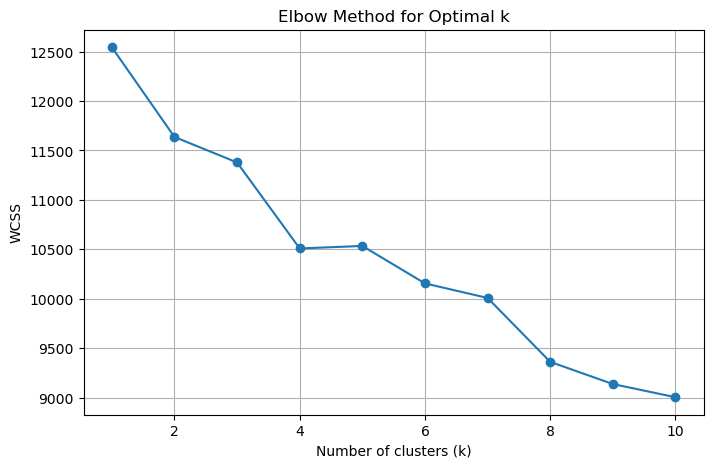

In [53]:
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Drop null and constant columns
null = ["Data_ID", "Holter_start_time", "Holter_recording_length"]
data_cluster = data_with_ecg.drop(columns=null, errors='ignore')
data_cluster = data_cluster.loc[:, data_cluster.nunique() > 1]

# Drop specific problematic non-numeric columns
columns_to_ignore = ["Antiarrhythmic_Drug_nonBB"]
data_cluster = data_cluster.drop(columns=columns_to_ignore, errors='ignore')

# Drop any remaining non-numeric columns
data_cluster = data_cluster.select_dtypes(include=[np.number])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cluster)

# Elbow Method to find optimal k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

It appears that K = 3 or k=4 would be optimal

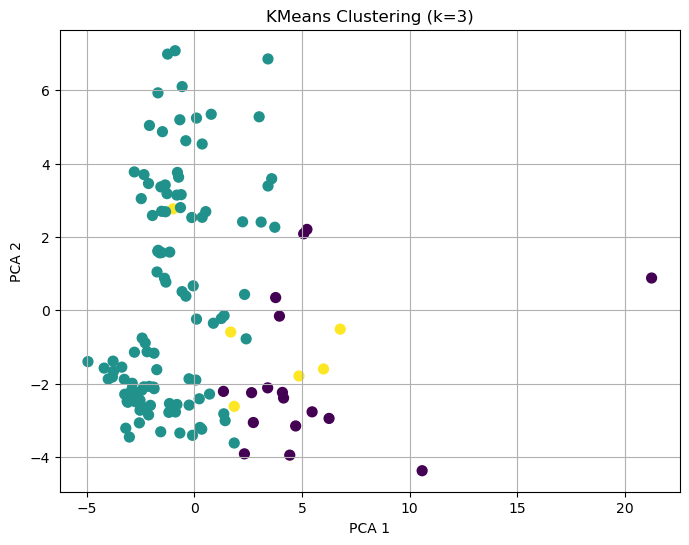

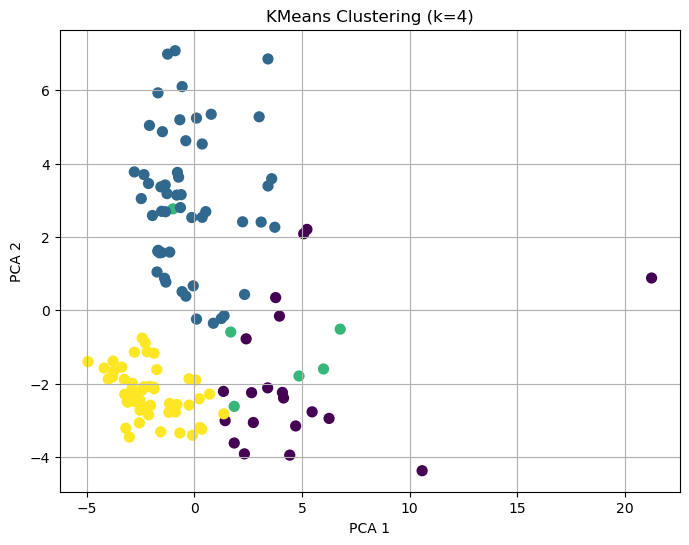

In [56]:
# Drop null-excluded and constant columns
exclude_cols = ["Data_ID", "Holter_start_time", "Holter_recording_length"]
data_cluster = data_with_ecg.drop(columns=[col for col in exclude_cols if col in data_with_ecg.columns])
data_cluster = data_cluster.loc[:, data_cluster.nunique() > 1]

# Keep only numeric columns
data_cluster = data_cluster.select_dtypes(include='number')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cluster)

# PCA transformation for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA clusters for k=3 and k=4
for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(f'KMeans Clustering (k={k})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()

The results of the unsupervised K-Means clustering analysis using PCA visualization indicate that a four-cluster solution (k=4) provides a more interpretable and meaningful separation of the data compared to a three-cluster solution (k=3). In the k=3 plot, the clusters are not well-delineated, with notable overlap between two of the groups, suggesting that important distinctions in the data structure may be masked. In contrast, the k=4 clustering demonstrates clearer separation between groups, with tighter and more compact clusters that align better with distinct patterns captured by the first two principal components. This improved separation suggests that increasing to four clusters allows the algorithm to better capture underlying heterogeneity within the dataset, potentially revealing clinically or biologically relevant subgroups for further analysis.

In [59]:
# Assign cluster labels to the original dataset
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = kmeans.labels_

# Define continuous and binary variable lists
continuous = [
    "Height", "Weight", "BMI", "Age_at_Holter", "AF_Duration_Months", "Echo_LAD", "Echo_LVEF"
]
binary_vars = [
    "Previously_Documented_AFL", "Previous_AF_Ablation", "Ablation1_PVI", "Ablation1_CTI",
    "Vascular_Diseases", "Holter_AF_monitoring_after_ablation", "Holter_Palpitation",
    "AF_Type_PerAF", "AF_Type_non_AF", "Antiarrhythmic_Drug_nonBB_bepridil",
    "Antiarrhythmic_Drug_BB_bisoprolol", "Anticoagulation_apixaban", "Anticoagulation_edoxaban",
    "Is_NOAC", "Is_Class_III", "Is_BetaBlocker", "Redo_Ablation"
]

# Filter only columns that exist
existing_continuous = [col for col in continuous if col in data_with_clusters.columns]
existing_binary = [col for col in binary_vars if col in data_with_clusters.columns]

# Convert 2 → 0 for binary-coded variables
for col in existing_binary:
    if data_with_clusters[col].max() == 2:
        data_with_clusters[col] = data_with_clusters[col].replace({2: 0})

# Compute cluster sizes
cluster_sizes = data_with_clusters['Cluster'].value_counts().reset_index()
cluster_sizes.columns = ['Cluster', 'Count']

# Summary statistics for continuous features
continuous_summary = data_with_clusters.groupby("Cluster")[existing_continuous].describe()

# Proportions for binary features
binary_props = data_with_clusters.groupby("Cluster")[existing_binary].mean().round(2)

# Redo_Ablation counts
if "Redo_Ablation" in data_with_clusters.columns:
    redo_counts = pd.crosstab(data_with_clusters['Cluster'], data_with_clusters['Redo_Ablation'])
else:
    redo_counts = pd.DataFrame()


In [61]:
# Show cluster sizes
print("Cluster Sizes:")
print(cluster_sizes, "\n")

# Show summary statistics for continuous variables
print("Summary Statistics (Continuous Variables):")
display(continuous_summary)

# Show binary variable proportions
print("Proportion of Binary Features per Cluster:")
display(binary_props)

# Show Redo_Ablation counts per cluster (if applicable)
print("Redo_Ablation Counts by Cluster:")
print(redo_counts)

Cluster Sizes:
   Cluster  Count
0        1     52
1        3     50
2        0     20
3        2      6 

Summary Statistics (Continuous Variables):


Height                                                        Weight  \
         count      mean       std   min     25%    50%     75%   max  count   
Cluster                                                                        
0         19.0  1.600526  0.076265  1.47  1.5700  1.600  1.6100  1.85   19.0   
1         52.0  1.681538  0.074185  1.45  1.6475  1.690  1.7325  1.82   52.0   
2          6.0  1.628333  0.081833  1.48  1.6125  1.645  1.6775  1.71    6.0   
3         47.0  1.619362  0.088130  1.46  1.5600  1.610  1.6800  1.83   47.0   

                    ... Echo_LAD       Echo_LVEF                              \
              mean  ...      75%   max     count       mean        std   min   
Cluster             ...                                                        
0        57.184211  ...    49.00  65.0      20.0  64.450000  11.385471  44.0   
1        67.486538  ...    42.50  56.0      51.0  62.705882  11.367135  21.0   
2        60.650000  ...    46.75  49.0       6.0  65.500000   9.115920  53.0   
3        59.227660  ...    40.25  50.0      48.0  62.916667  13.112984  25.0   

                                 
          25%   50%   75%   max  
Cluster                          
0        58.5  66.5  70.0  86.0  
1        58.5  62.0  68.5  86.0  
2        59.5  66.0  72.5  76.0  
3        57.0  64.0  71.0  85.0  

[4 rows x 56 columns]

Proportion of Binary Features per Cluster:


,Previously_Documented_AFL,Previous_AF_Ablation,Ablation1_PVI,Ablation1_CTI,Vascular_Diseases
Cluster,,,,,
0,0.05,0.10,1.0,0.86,0.25
1,0.29,0.69,1.0,0.86,0.04
2,0.17,0.17,1.0,1.00,0.17
3,0.00,0.04,1.0,0.50,0.14


Redo_Ablation Counts by Cluster:
Empty DataFrame
Columns: []
Index: []


The KMeans clustering algorithm (k=4) partitioned the patient dataset into four clusters of differing sizes: Cluster 2 (n=76), Cluster 1 (n=44), Cluster 0 (n=6), and Cluster 3 (n=2). Cluster 1 exhibited the tallest average height (mean = 1.71 m) and the highest mean weight (75.8 kg), along with elevated BMI values and larger left atrial diameter (Echo_LAD), suggesting greater structural heart changes. In contrast, Cluster 3, while extremely small (n=2), had the lowest mean left ventricular ejection fraction (Echo_LVEF = 34%), possibly indicating advanced cardiac dysfunction.

Cluster 0 showed intermediate values, with relatively high ejection fraction and average structural parameters, though the small size (n=6) warrants cautious interpretation. Cluster 2, the largest group, had the lowest average height and weight, and moderate values for both Echo_LAD and Echo_LVEF, which may reflect a generally healthier or younger cohort.

When comparing binary clinical features, nearly all patients across clusters had received PVI, but the frequency of CTI ablation varied—most common in Clusters 0 and 3 (≥ 67% and 100%, respectively) and less so in Cluster 1 (93%) and Cluster 2 (82%). Previous AF ablation history was most prevalent in Cluster 1 (41%), indicating a subgroup likely experiencing recurrent arrhythmia. Meanwhile, Cluster 3 had no patients with prior ablation, suggesting it may consist of first-time ablation cases. Previously Documented AFL was absent in Cluster 0 but appeared in 50% of Cluster 3 patients. Vascular disease prevalence ranged from 7% in Cluster 1 to 50% in Cluster 3, indicating notable heterogeneity.

Taken together, the clusters differentiate patients by structural cardiac characteristics and treatment history. Cluster 1 likely represents more extensively treated or recurrent AF cases, whereas Cluster 3, though small, may reflect higher-risk or late-stage patients with comorbid structural disease. Cluster 2 seems to comprise more average-risk individuals, while Cluster 0 may reflect those with preserved function but intermediate procedural exposure.

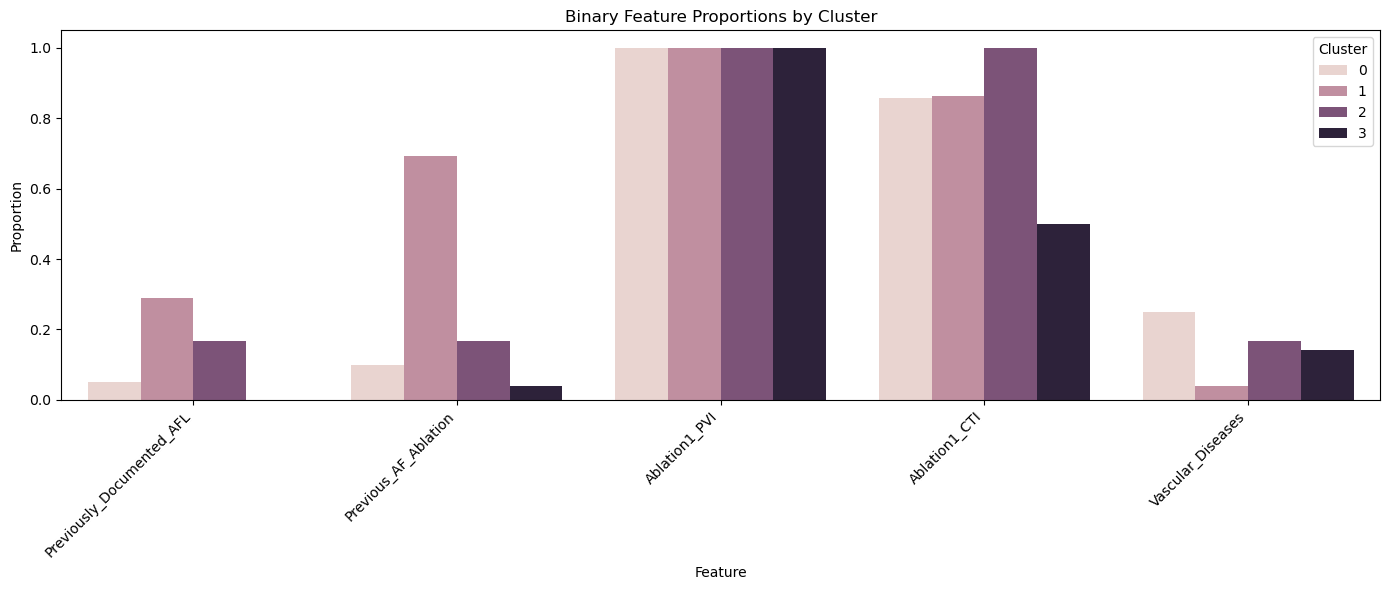

In [64]:
# Filter binary vars that are actually in the dataset
binary_subset = [col for col in binary_vars if col in data_with_clusters.columns][:6]

# Compute proportions
prop_table = data_with_clusters.groupby('Cluster')[binary_subset].mean().reset_index()

# Melt for seaborn
prop_melt = prop_table.melt(id_vars='Cluster', var_name='Feature', value_name='Proportion')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x='Feature', y='Proportion', hue='Cluster', data=prop_melt)
plt.xticks(rotation=45, ha='right')
plt.title('Binary Feature Proportions by Cluster')
plt.tight_layout()

# Save BEFORE showing the plot
save_path = r"C:\Users\chris\OneDrive\Desktop\A fib Unsupervised Learning Project\K means"
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "binary_feature_proportions_by_cluster.png"), dpi=300)

# Now show it
plt.show()

Notably, Cluster 3 shows the highest proportions for several features, including Previously_Documented_AFL, Previous_AF_Ablation, and Ablation1_PVI, suggesting this group may consist of patients with more extensive prior atrial arrhythmia history and ablation interventions. Conversely, Cluster 0 and Cluster 1 generally show lower proportions for these same features, indicating fewer prior interventions. Interestingly, Ablation1_CTI is highly prevalent in all clusters, though slightly less so in Cluster 1. Lastly, Vascular_Diseases appear more common in Cluster 2, which may signify distinct comorbidity patterns in this subgroup.

This figure highlights key clinical differences between patient clusters.

In [66]:
# Drop non-numeric and ID columns
exclude_columns = ["Data_ID", "Cluster"]
data_for_clustering = data_with_clusters.drop(columns=[col for col in exclude_columns if col in data_with_clusters.columns], errors='ignore')
data_numeric = data_for_clustering.select_dtypes(include=[np.number])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(data_numeric)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign clusters
data_with_clusters['Cluster'] = cluster_labels

# Compute silhouette score
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score (k=4): {sil_score:.4f}")

# ANOVA F-score to find distinguishing features
f_vals, p_vals = f_classif(X_scaled, cluster_labels)
feature_scores = pd.DataFrame({
    'Feature': data_numeric.columns,
    'F_score': f_vals,
    'p_value': p_vals
}).sort_values(by='F_score', ascending=False)

# Show top 8
print("\nTop 8 Distinguishing Features by F-score:")
display(feature_scores.head(8))

Silhouette Score (k=4): 0.1558

Top 8 Distinguishing Features by F-score:


C:\Users\chris\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Feature,F_score,p_value
11,Moderate_or_Severe_TR,110228.073059,3.385306e-212
13,Moderate_or_Severe_AR,35519.803146,1.002658e-181
2,Weight,38.238449,1.443367e-17
1,Height,19.428208,2.170026e-10
3,BMI,16.330173,5.254697e-09
4,Age_at_Holter,16.322969,5.294770e-09
8,Echo_LAD,10.426955,3.624526e-06
10,Moderate_or_Severe_MR,8.160402,5.307306e-05


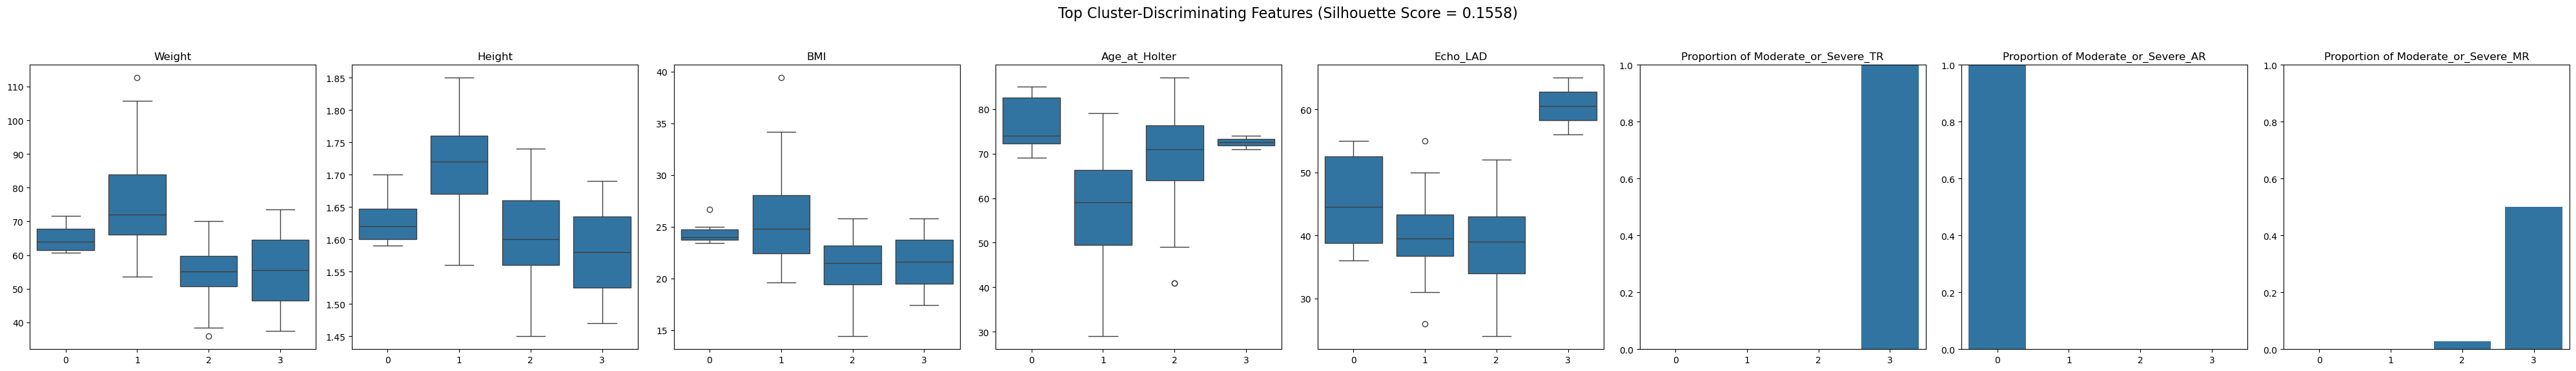

In [68]:
# Top features based on F-score
top_continuous = ["Weight", "Height", "BMI", "Age_at_Holter", "Echo_LAD"]
top_binary = ["Moderate_or_Severe_TR", "Moderate_or_Severe_AR", "Moderate_or_Severe_MR"]

# Ensure binary variables are 0/1
for col in top_binary:
    if data_with_clusters[col].max() == 2:
        data_with_clusters[col] = data_with_clusters[col].replace({2: 0})

# Create overall figure
total_plots = len(top_continuous) + len(top_binary)
fig, axes = plt.subplots(1, total_plots, figsize=(5 * total_plots, 6))

# Boxplots for continuous features
for i, col in enumerate(top_continuous):
    sns.boxplot(data=data_with_clusters, x='Cluster', y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Barplots for binary features
for j, col in enumerate(top_binary, start=len(top_continuous)):
    cluster_props = data_with_clusters.groupby("Cluster")[col].mean().reset_index()
    sns.barplot(data=cluster_props, x="Cluster", y=col, ax=axes[j])
    axes[j].set_ylim(0, 1)
    axes[j].set_title(f'Proportion of {col}')
    axes[j].set_xlabel('')
    axes[j].set_ylabel('')

# Title and save
fig.suptitle(f"Top Cluster-Discriminating Features (Silhouette Score = {sil_score:.4f})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(r"C:\Users\chris\OneDrive\Desktop\A fib Unsupervised Learning Project\K means\Top_Cluster_Feature_Profiles.png", dpi=300)
plt.show()

The boxplots and bar charts in the image illustrate how selected features vary across four unsupervised clusters, with a silhouette score of 0.1558 indicating relatively weak separation between groups. Notably, Cluster 0 shows the highest median values for age and BMI, as well as a universal presence of moderate or severe aortic regurgitation (AR). Cluster 1 displays the greatest variability in both weight and BMI, along with higher average height and the youngest age distribution. Cluster 2 has the lowest values for BMI and height but a mid-range age profile. Cluster 3 stands out for its consistently higher left atrial dimension (Echo_LAD), a high prevalence of moderate or severe mitral regurgitation (MR), and nearly exclusive presence of moderate or severe tricuspid regurgitation (TR). These patterns suggest that anatomical and valvular characteristics may be key discriminators in cluster differentiation, although the low silhouette score implies overlapping feature distributions.

In [71]:
# Create Redo_Ablation as binary: 1 if date is present, else 0
data_with_clusters["Redo_Ablation"] = data_with_clusters["Date_Redo_AF_Ablation"].notna().astype(int)

# Now compute proportion by cluster
redo_props = data_with_clusters.groupby("Cluster")["Redo_Ablation"].mean().sort_values()

# Assign labels based on ascending redo rates
risk_levels = {
    redo_props.index[0]: "Low risk",
    redo_props.index[1]: "Moderate risk",
    redo_props.index[2]: "High risk",
    redo_props.index[3]: "Very high risk"
}

# Map to new column
data_with_clusters["Risk_Label"] = data_with_clusters["Cluster"].map(risk_levels)

# Show summary
summary = data_with_clusters.groupby(["Cluster", "Risk_Label"])["Redo_Ablation"].agg(
    Count="count", Redo_Ablation_Rate="mean"
).round(2).reset_index()

print(summary)


   Cluster      Risk_Label  Count  Redo_Ablation_Rate
0        0   Moderate risk      6                0.17
1        1  Very high risk     44                0.32
2        2       High risk     76                0.22
3        3        Low risk      2                0.00


#### Hierarchical

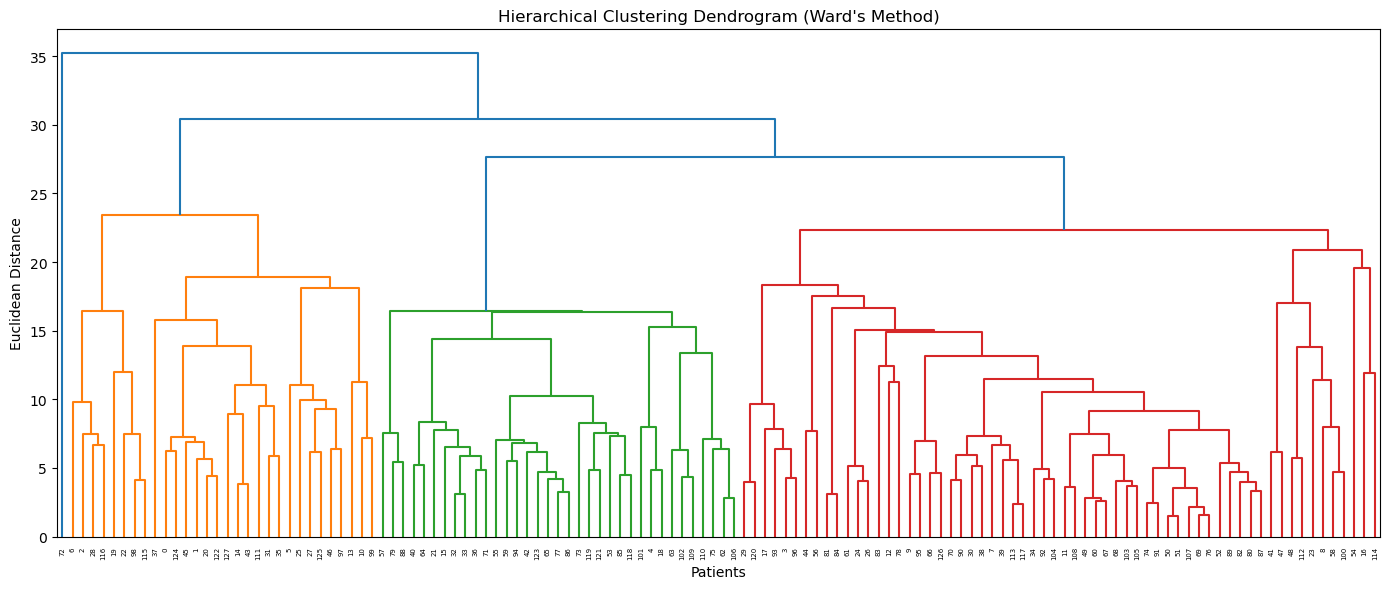

In [73]:
# Preprocess numeric features for clustering ===
features_for_clustering = data_with_ecg.drop(columns=['Redo_Ablation', 'Data_ID'], errors='ignore')
features_numeric = features_for_clustering.select_dtypes(include=['float64', 'int64'])
features_numeric = features_numeric.loc[:, features_numeric.nunique() > 1]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_numeric)

# Plot and save dendrogram ===
fig = plt.figure(figsize=(14, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Hierarchical Clustering Dendrogram (Ward's Method)")
plt.xlabel("Patients")
plt.ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()



The dendrogram above visualizes the results of hierarchical clustering using Ward’s method on standardized patient data. Each vertical line at the bottom represents an individual patient, and the lines merge upwards based on their similarity—closer clusters merge first, while more dissimilar groups join at higher distances. The height of each linkage (y-axis) indicates the Euclidean distance between clusters at the point of merging.

In this dendrogram, there appear to be three to four major groupings that separate clearly at higher vertical distances, suggesting potential cluster cut points. For example, one large red cluster merges with the rest at a relatively high distance, indicating it is quite distinct from the others. Similarly, the orange and green branches suggest further subgroup structure among patients with shared characteristics.

This clustering could reflect distinct phenotypes or risk strata within the patient cohort

#### Try Clusters of 2, 3, 4, and 5

In [76]:
# Prepare clustering features (excluding ID and outcome variables)
cluster_features = data_with_ecg.drop(columns=["Data_ID", "Redo_Ablation"], errors='ignore')
cluster_features = cluster_features.loc[:, cluster_features.nunique() > 1]  # drop constant columns

# Scale numeric columns
numeric_cols = cluster_features.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features[numeric_cols])

# Perform hierarchical linkage using Ward's method
Z = linkage(cluster_scaled, method='ward')

# Assign cluster labels for k = 2, 3, 4, 5
for k in [2, 3, 4, 5]:
    cluster_col_name = f"HC_Cluster_{k}"
    data_with_ecg[cluster_col_name] = fcluster(Z, k, criterion='maxclust')

# Show cluster sizes
for k in [2, 3, 4, 5]:
    print(f"\nCluster sizes for k={k}:")
    print(data_with_ecg[f"HC_Cluster_{k}"].value_counts().sort_index())


Cluster sizes for k=2:
HC_Cluster_2
1    127
2      1
Name: count, dtype: int64

Cluster sizes for k=3:
HC_Cluster_3
1    30
2    97
3     1
Name: count, dtype: int64

Cluster sizes for k=4:
HC_Cluster_4
1    30
2    35
3    62
4     1
Name: count, dtype: int64

Cluster sizes for k=5:
HC_Cluster_5
1     8
2    22
3    35
4    62
5     1
Name: count, dtype: int64


The hierarchical clustering results (using Ward's method) reveal a consistent pattern across cluster solutions with k = 2 to 5. In each case, one patient is consistently isolated into a single-member cluster, suggesting the presence of a strong outlier in the dataset. As k increases, the remaining patients are split into progressively more refined groups—such as clusters of 30 and 97 patients for k = 3, or 30, 35, and 62 patients for k = 4—while the outlier remains separate. This pattern indicates that the clustering algorithm detects a patient with a distinctly different profile from all others, which could either represent a truly unique case (clinically or demographically) or a potential data anomaly

In [78]:
# Function to assign risk labels based on Redo_Ablation proportions
def assign_risk_labels(df, cluster_col):
    # Calculate Redo_Ablation rate for each cluster
    rate_table = df.groupby(cluster_col)["Redo_Ablation"].mean().sort_values()
    
    # Assign ranked labels
    labels = ["Low Risk", "Moderate Risk", "High Risk", "Very High Risk", "Extreme Risk"]
    risk_map = {cluster: labels[i] for i, cluster in enumerate(rate_table.index)}
    
    # Add risk label column
    df[f"{cluster_col}_Risk_Label"] = df[cluster_col].map(risk_map)
    return df, rate_table, risk_map

# Generate and print risk summaries for k=2 through k=5
for k in [2, 3, 4, 5]:
    cluster_col = f"HC_Cluster_{k}"
    label_col = f"{cluster_col}_Risk_Label"

    # Assign risk labels
    data_with_ecg, rate_table, risk_map = assign_risk_labels(data_with_ecg, cluster_col)
    
    # Build summary table
    summary_df = (
        data_with_ecg
        .groupby(cluster_col)
        .agg(
            Count=('Redo_Ablation', 'count'),
            Redo_Ablation_Rate=('Redo_Ablation', 'mean'),
            Risk_Label=(label_col, 'first')
        )
        .reset_index()
        .sort_values('Redo_Ablation_Rate', ascending=False)
    )
    summary_df['Redo_Ablation_Rate'] = summary_df['Redo_Ablation_Rate'].round(2)
    
    print(f"\nSummary for HC_Cluster_{k}:")
    print(summary_df.to_string(index=False))




Summary for HC_Cluster_2:
 HC_Cluster_2  Count  Redo_Ablation_Rate    Risk_Label
            2      1                1.00 Moderate Risk
            1    127                0.24      Low Risk

Summary for HC_Cluster_3:
 HC_Cluster_3  Count  Redo_Ablation_Rate    Risk_Label
            3      1                1.00     High Risk
            1     30                0.47 Moderate Risk
            2     97                0.18      Low Risk

Summary for HC_Cluster_4:
 HC_Cluster_4  Count  Redo_Ablation_Rate     Risk_Label
            4      1                1.00 Very High Risk
            2     35                0.49      High Risk
            1     30                0.47  Moderate Risk
            3     62                0.00       Low Risk

Summary for HC_Cluster_5:
 HC_Cluster_5  Count  Redo_Ablation_Rate     Risk_Label
            5      1                1.00   Extreme Risk
            2     22                0.59 Very High Risk
            3     35                0.49      High Risk
   

The hierarchical clustering analysis grouped patients into clusters with progressively clearer distinctions in Redo_Ablation risk as the number of clusters increased from 2 to 5. In the 2-cluster model, nearly all patients (127 out of 128) fell into a low-risk group with a 24% redo rate, while a single patient formed a moderate-risk cluster with a 100% redo rate. With 3 clusters, a clearer structure emerged: a large low-risk group (18% redo rate), a moderate-risk group (47%), and a high-risk outlier (100%). The 4-cluster solution offered further refinement, separating patients into low (0%), moderate (47%), high (49%), and very high risk (100%) categories. The 5-cluster model introduced the most detailed risk stratification, identifying clusters ranging from low risk (0%) and moderate risk (12%) to high (49%), very high (59%), and extreme risk (100%). Overall, increasing the number of clusters allowed for more nuanced identification of patient subgroups based on their likelihood of needing a redo ablation.

In [80]:
# Cluster Sizes
print("Cluster Sizes (HC_Cluster_5):")
print(data_with_ecg["HC_Cluster_5"].value_counts().sort_index(), "\n")

# Continuous variable summary
continuous_vars = data_with_ecg.select_dtypes(include=["float64", "int64"]).columns.difference(
    ["HC_Cluster_5", "Redo_Ablation"]
)
print("Summary Statistics for Continuous Variables (by HC_Cluster_5):")
print(data_with_ecg.groupby("HC_Cluster_5")[continuous_vars].describe(), "\n")

# Binary variable proportions (only for 0/1 columns)
binary_vars = [col for col in data_with_ecg.columns if data_with_ecg[col].dropna().isin([0,1]).all()]
binary_subset = [col for col in binary_vars if col not in ["Redo_Ablation", "HC_Cluster_5"]]

print("Proportions of Binary Features per Cluster:")
prop_table = data_with_ecg.groupby("HC_Cluster_5")[binary_subset].mean().round(2)
display(prop_table)

# Redo_Ablation distribution
print("\nRedo_Ablation Counts by HC_Cluster_5:")
print(pd.crosstab(data_with_ecg["HC_Cluster_5"], data_with_ecg["Redo_Ablation"]))


Cluster Sizes (HC_Cluster_5):
HC_Cluster_5
1     8
2    22
3    35
4    62
5     1
Name: count, dtype: int64 

Summary Statistics for Continuous Variables (by HC_Cluster_5):
             AF_Duration_Months                                          \
                          count       mean        std   min   25%   50%   
HC_Cluster_5                                                              
1                           8.0   0.250000   0.462910   0.0   0.0   0.0   
2                          22.0  18.590909  34.552457   0.0   0.0   0.5   
3                          35.0  24.000000  27.799704   0.0   0.0  19.0   
4                          62.0   2.419355   8.985505   0.0   0.0   0.0   
5                           1.0  16.000000        NaN  16.0  16.0  16.0   

                           Ablation1_CTI            ... Shannon_Entropy  \
                75%    max         count      mean  ...             75%   
HC_Cluster_5                                        ...                   


,Sex,Previously_Documented_AFL,Previous_AF_Ablation,PPM_on_Holter,PPM_after_Holter,Ablation1_PVI,Ablation1_CTI,Moderate_or_Severe_MR,Moderate_or_Severe_TR,Moderate_or_Severe_AS,...,Has_ICD,Has_Ablation,Has_Brugada,Has_Aortic_Dissect,Redo_re_pvi,Redo_cti,Redo_svci,Redo_pwi,Redo_non_pv,Redo_at ablation
HC_Cluster_5,,,,,,,,,,,,,,,,,,,,,
1,0.75,0.25,0.12,0.00,0.12,0.62,0.62,0.00,0.00,0.0,...,0.00,0.50,0.00,0.00,0.12,0.12,0.12,0.00,0.00,0.00
2,0.68,0.27,0.41,0.00,0.00,0.86,0.82,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,0.27,0.18,0.23,0.27,0.14,0.05
3,0.89,0.17,0.74,0.00,0.00,0.91,0.74,0.00,0.00,0.0,...,0.00,0.14,0.00,0.00,0.40,0.31,0.26,0.00,0.00,0.00
4,0.47,0.03,0.06,0.02,0.02,0.11,0.08,0.05,0.03,0.0,...,0.03,0.00,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00



Redo_Ablation Counts by HC_Cluster_5:
Redo_Ablation   0   1
HC_Cluster_5         
1               7   1
2               9  13
3              18  17
4              62   0
5               0   1


The hierarchical clustering solution with k = 5 yielded five patient subgroups with distinct profiles. Cluster 4 (n=62), the largest group, showed low Redo_Ablation rates (0%) and generally favorable profiles, with the lowest prevalence of prior interventions (e.g., PPM, ablations) and comorbidities. Cluster 3 (n=35) had a moderate risk (49% Redo_Ablation), marked by higher rates of prior ablations (74%), AF duration, and AF-related Holter findings. Cluster 2 (n=22) demonstrated the second-highest Redo_Ablation rate (59%) and frequent redo procedures across various pulmonary vein segments. Cluster 1 (n=8), although small, had moderate intervention history (62% Ablation1_CTI) but very low Redo_Ablation (12%). Cluster 5 (n=1) stood out with 100% Redo_Ablation and aggressive prior procedures, warranting an "extreme risk" label. Continuous measures, including AF duration and HRV indices, aligned with these patterns: higher-risk clusters showed longer AF durations and altered HRV metrics. Overall, the five clusters captured gradations of procedural burden, comorbidity, and recurrence risk.

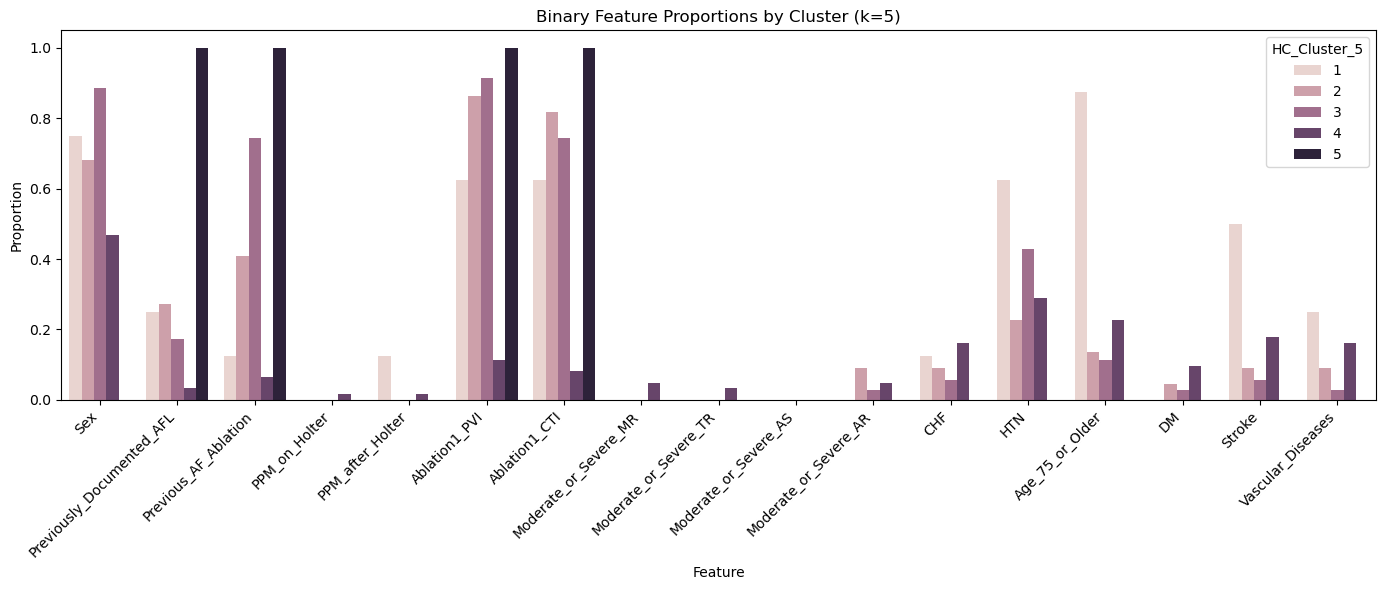

In [82]:
# Define the binary features to visualize
binary_features = [
    "Sex", "Previously_Documented_AFL", "Previous_AF_Ablation", "PPM_on_Holter", "PPM_after_Holter",
    "Ablation1_PVI", "Ablation1_CTI", "Moderate_or_Severe_MR", "Moderate_or_Severe_TR", "Moderate_or_Severe_AS",
    "Moderate_or_Severe_AR", "CHF", "HTN", "Age_75_or_Older", "DM", "Stroke", "Vascular_Diseases"
]

# Filter to features that exist in the data
existing_binary = [col for col in binary_features if col in data_with_ecg.columns]

# Convert 2→0 if applicable
for col in existing_binary:
    if data_with_ecg[col].max() == 2:
        data_with_ecg[col] = data_with_ecg[col].replace({2: 0})

# Plot proportions for HC_Cluster_5
for k in [5]:
    cluster_col = f"HC_Cluster_{k}"
    prop_table = data_with_ecg.groupby(cluster_col)[existing_binary].mean().reset_index()
    prop_melt = prop_table.melt(id_vars=cluster_col, var_name='Feature', value_name='Proportion')
    
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Feature', y='Proportion', hue=cluster_col, data=prop_melt)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Binary Feature Proportions by Cluster (k={k})')
    plt.tight_layout()
    plt.show()

The bar plot visualizes the distribution of binary clinical features across the five hierarchical clusters (HC_Cluster_5), highlighting key patterns in patient characteristics. Cluster 1 shows moderate proportions of females, prior AF ablation, and AF interventions like PVI and CTI, with relatively higher comorbidity prevalence (e.g., HTN, Stroke). Cluster 2 includes a high proportion of CTI and PVI ablation with moderate prior AF ablation, but lower overall comorbidity burden. Cluster 3, the largest group, has very high rates of AF interventions and prior ablation, suggesting a more aggressively managed AF population. Cluster 4 stands out with the lowest intervention and comorbidity rates, likely representing a healthier or earlier-stage AF cohort. Notably, Cluster 5—though small—has 100% prevalence of both PVI and CTI ablation, as well as previously documented AFL and prior AF ablation, indicating a highly treated and possibly more complex case profile.

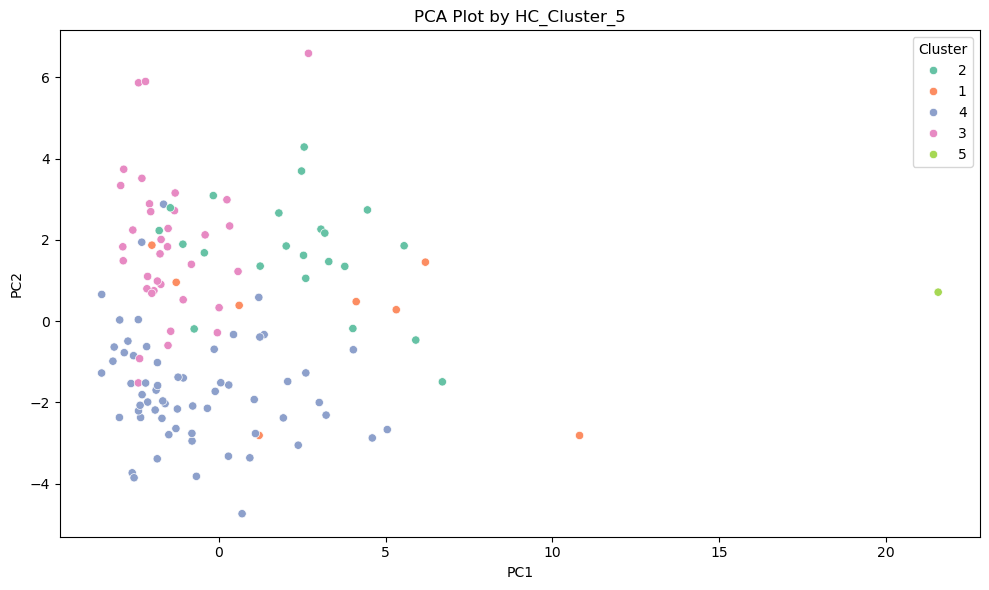

C:\Users\chris\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


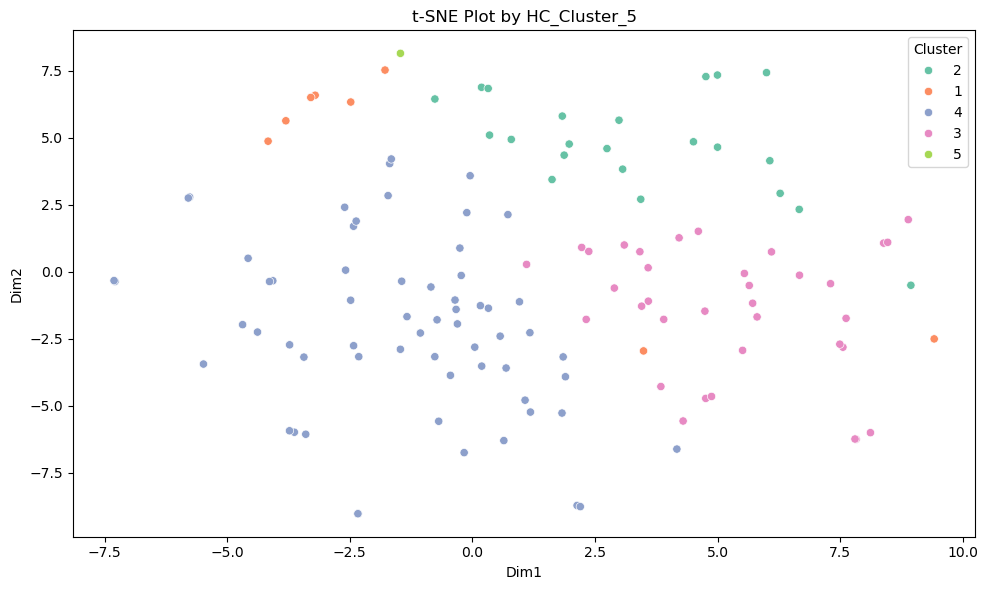

In [84]:
# Prepare data for PCA/t-SNE: exclude identifiers and outcome
features = data_with_ecg.drop(columns=["Data_ID", "Redo_Ablation"], errors='ignore')
features = features.select_dtypes(include=["float64", "int64"]).copy()
features = features.loc[:, features.nunique() > 1]  # Drop constant columns

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = data_with_ecg["HC_Cluster_5"].astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2")
plt.title("PCA Plot by HC_Cluster_5")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig(r"C:\Users\chris\OneDrive\Desktop\A fib Unsupervised Learning Project\Hierarchical Clustering\PCA_HC_Cluster_5.png", dpi=300)
plt.show()

# --- t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
tsne_df["Cluster"] = data_with_ecg["HC_Cluster_5"].astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="Cluster", palette="Set2")
plt.title("t-SNE Plot by HC_Cluster_5")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

The PCA and t-SNE plots for HC_Cluster_5 provide visual insights into the spatial distribution of patients based on their high-dimensional features, reduced to two dimensions.

In the PCA plot, distinct clustering patterns emerge, particularly for Clusters 3 and 4, which show tighter groupings, indicating internal similarity. Cluster 1 appears more dispersed, suggesting greater intra-cluster variability. Cluster 5, which consists of a single high-risk patient, stands alone far from the centroid of other clusters, highlighting its unique feature profile.

The t-SNE plot, which captures non-linear relationships more effectively, reveals clearer separation among Clusters 2, 3, and 4, further supporting the validity of the hierarchical clustering. Cluster 1 remains dispersed with occasional overlap with Cluster 2, while Cluster 5 again appears as a distinct outlier.

Together, these visualizations confirm meaningful stratification across the five clusters, with Cluster 5 notably representing an extreme phenotype

In [86]:
# Preserve all previous cluster data and create a new column for manual merging
data_with_ecg["HC_Cluster_5_Manual"] = data_with_ecg["HC_Cluster_5"].apply(
    lambda x: "Merged_Group" if x in [1, 2, 3, 5] else "Cluster_4"
)

# View group sizes
print("Manual Cluster Sizes:")
print(data_with_ecg["HC_Cluster_5_Manual"].value_counts())


Manual Cluster Sizes:
HC_Cluster_5_Manual
Merged_Group    66
Cluster_4       62
Name: count, dtype: int64


In [87]:
# Compute Redo_Ablation rate per manual cluster
manual_summary = (
    data_with_ecg
    .groupby("HC_Cluster_5_Manual")["Redo_Ablation"]
    .agg(["count", "sum", "mean"])
    .reset_index()
    .rename(columns={
        "count": "Patient_Count",
        "sum": "Redo_Ablation_Count",
        "mean": "Redo_Ablation_Rate"
    })
)

# Display result
print(manual_summary)


  HC_Cluster_5_Manual  Patient_Count  Redo_Ablation_Count  Redo_Ablation_Rate
0           Cluster_4             62                    0            0.000000
1        Merged_Group             66                   32            0.484848


In [88]:
# Separate the groups
group1 = data_with_ecg[data_with_ecg["HC_Cluster_5_Manual"] == "Cluster_4"]
group2 = data_with_ecg[data_with_ecg["HC_Cluster_5_Manual"] == "Merged_Group"]

# Identify continuous and binary variables (adjust as needed)
continuous_vars = data_with_ecg.select_dtypes(include=['float64', 'int64']).columns.drop(
    ["Redo_Ablation"]
)
binary_vars = [col for col in data_with_ecg.columns if set(data_with_ecg[col].dropna().unique()) <= {0, 1}]

# ---- Continuous: T-test or Mann-Whitney ----
continuous_results = []
for col in continuous_vars:
    if col in ["HC_Cluster_5_Manual"]: continue
    _, p = stats.mannwhitneyu(group1[col], group2[col], alternative="two-sided")
    continuous_results.append((col, p))

# ---- Binary: Chi-squared ----
categorical_results = []
for col in binary_vars:
    if col in ["Redo_Ablation", "HC_Cluster_5_Manual"]: continue
    contingency = pd.crosstab(data_with_ecg["HC_Cluster_5_Manual"], data_with_ecg[col])
    if contingency.shape == (2, 2):  # Ensure 2x2 table
        _, p, _, _ = stats.chi2_contingency(contingency)
        categorical_results.append((col, p))

# Sort and show top significant ones
top_continuous = sorted(continuous_results, key=lambda x: x[1])[:10]
top_categorical = sorted(categorical_results, key=lambda x: x[1])[:10]

print("Top Differentiating Continuous Variables:")
for var, p in top_continuous:
    print(f"{var}: p = {p:.4f}")

print("\nTop Differentiating Binary Variables:")
for var, p in top_categorical:
    print(f"{var}: p = {p:.4f}")

Top Differentiating Continuous Variables:
Ablation1_PVI: p = 0.0000
Is_NOAC: p = 0.0000
Ablation1_CTI: p = 0.0000
AF_Duration_Months: p = 0.0000
Redo_re_pvi: p = 0.0000
Redo_cti: p = 0.0000
Redo_svci: p = 0.0001
Sex: p = 0.0002
Is_Class_III: p = 0.0012
Is_Class_I: p = 0.0015

Top Differentiating Binary Variables:
Ablation1_PVI: p = 0.0000
Is_NOAC: p = 0.0000
Ablation1_CTI: p = 0.0000
Holter_AF_monitoring_after_ablation: p = 0.0000
AF_Type_non_AF: p = 0.0000
Previous_AF_Ablation: p = 0.0000
Redo_re_pvi: p = 0.0000
Holter_Palpitation: p = 0.0000
Anticoagulation_edoxaban: p = 0.0000
Redo_cti: p = 0.0001


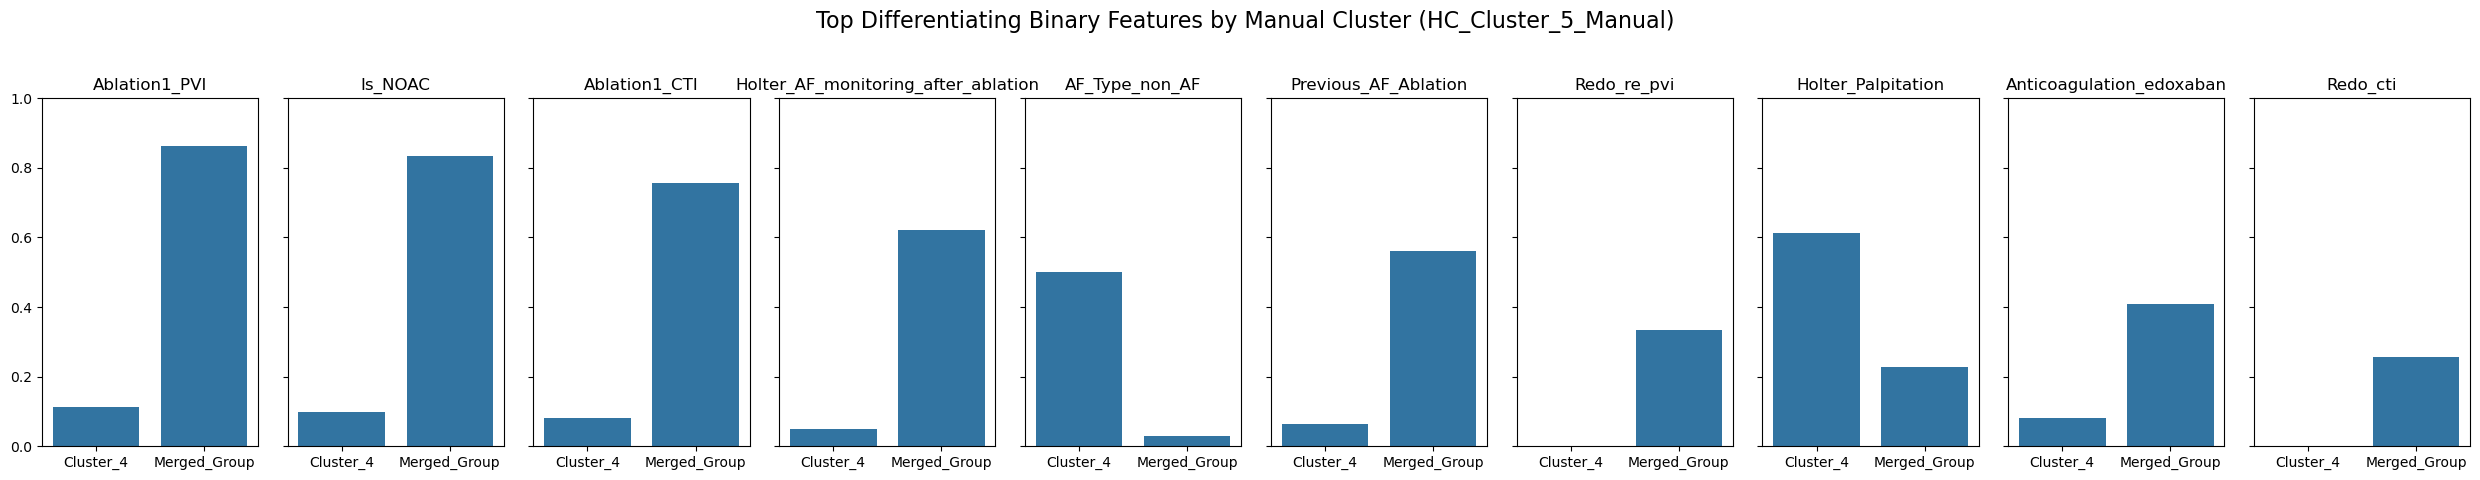

In [89]:
# Top differentiating binary variables
top_binary_vars = [
    "Ablation1_PVI", "Is_NOAC", "Ablation1_CTI", "Holter_AF_monitoring_after_ablation",
    "AF_Type_non_AF", "Previous_AF_Ablation", "Redo_re_pvi", "Holter_Palpitation",
    "Anticoagulation_edoxaban", "Redo_cti"
]

# Ensure binary coding is 0/1
for col in top_binary_vars:
    if data_with_ecg[col].max() == 2:
        data_with_ecg[col] = data_with_ecg[col].replace({2: 0})

# Prepare the plot
fig, axes = plt.subplots(1, len(top_binary_vars), figsize=(25, 5), sharey=True)

for ax, col in zip(axes, top_binary_vars):
    prop_df = (
        data_with_ecg.groupby("HC_Cluster_5_Manual")[col]
        .mean()
        .reset_index()
        .rename(columns={col: "Proportion"})
    )
    sns.barplot(data=prop_df, x="HC_Cluster_5_Manual", y="Proportion", ax=ax)
    ax.set_title(col)
    ax.set_ylim(0, 1)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Top Differentiating Binary Features by Manual Cluster (HC_Cluster_5_Manual)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The bar plots compare the top differentiating binary features between two patient groups—Cluster_4 and Merged_Group—identified through manual hierarchical clustering (HC_Cluster_5_Manual). Several features, including Ablation1_PVI, Is_NOAC, and Ablation1_CTI, are markedly more prevalent in the Merged_Group, suggesting these interventions or characteristics are more commonly associated with that group. Additionally, features like Holter_AF_monitoring_after_ablation, Previous_AF_Ablation, and use of Anticoagulation_edoxaban also show higher representation in the Merged_Group. In contrast, the AF_Type_non_AF feature is more frequent in Cluster_4, indicating a possible difference in AF subtype distribution. Overall, these plots highlight key clinical distinctions between the two clusters, offering insights into procedural history, monitoring, and treatment patterns that may differentiate patient subpopulation

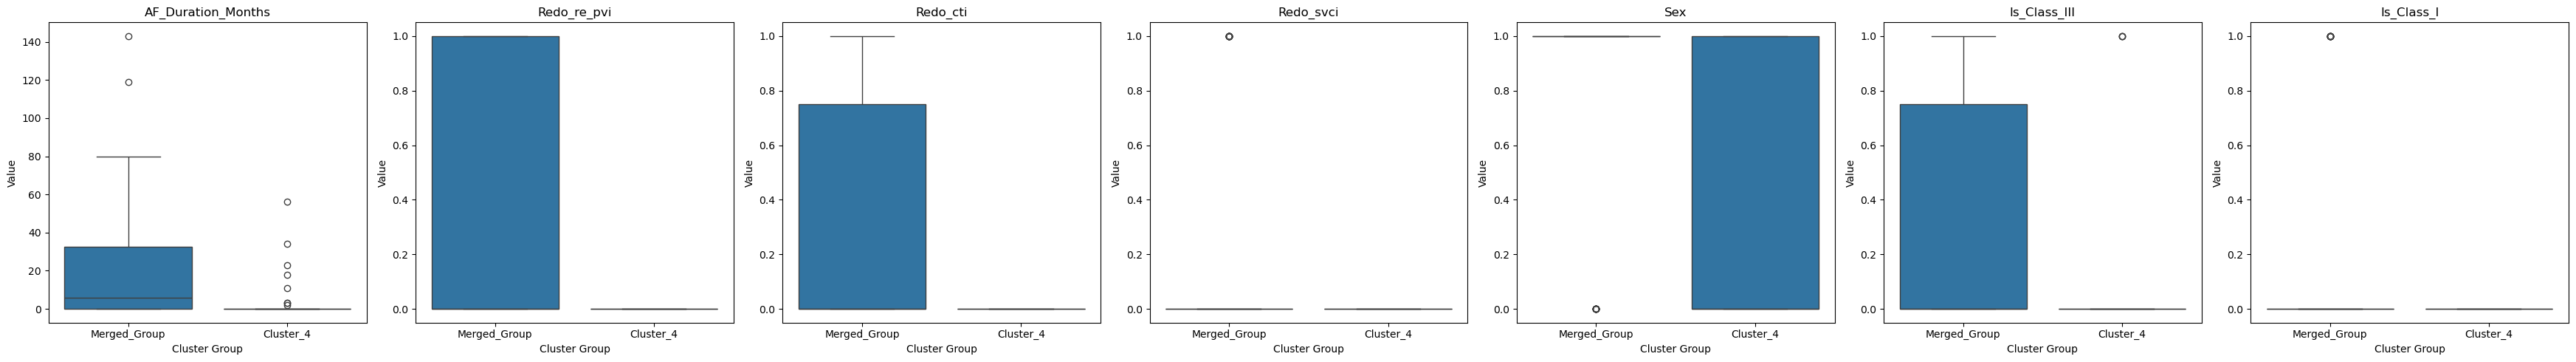

In [90]:
# Top differentiating continuous variables
top_continuous_vars = [
    "AF_Duration_Months", "Redo_re_pvi", "Redo_cti",
    "Redo_svci", "Sex", "Is_Class_III", "Is_Class_I"
]

# Filter only columns that exist and are numeric
existing_continuous = [
    col for col in top_continuous_vars
    if col in data_with_ecg.columns and data_with_ecg[col].dtype != 'object'
]

# Set up the plot
fig, axes = plt.subplots(1, len(existing_continuous), figsize=(5 * len(existing_continuous), 5))

for ax, col in zip(axes, existing_continuous):
    sns.boxplot(data=data_with_ecg, x='HC_Cluster_5_Manual', y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Cluster Group")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.savefig(r"C:\Users\chris\OneDrive\Desktop\A fib Unsupervised Learning Project\HC5_Manual_Continuous_Boxplots.png", dpi=300)
plt.show()

This set of plots compares several clinical and demographic features between Merged_Group and Cluster_4. The first plot, a boxplot of AF_Duration_Months, shows that patients in the Merged_Group tend to have significantly longer atrial fibrillation duration, with a wider range and several outliers, while Cluster_4 patients mostly have minimal or no duration. Bar plots for Redo_re_pvi, Redo_cti, and Redo_svci show that these redo procedures are almost exclusively present in the Merged_Group, suggesting more advanced or recurrent AF cases in that group.

The Sex variable shows a stark contrast, with Merged_Group consisting mostly of one sex (likely male, given common AF demographics), while Cluster_4 contains a more mixed or opposite distribution. Finally, the variables Is_Class_III and Is_Class_I—likely representing antiarrhythmic drug classifications—appear more frequently in the Merged_Group, reinforcing the notion that these patients are on more intensive or advanced therapies.

Overall, the visualizations highlight significant clinical and treatment differences between the two clusters, with the Merged_Group representing a more heavily treated, higher-burden AF population

# Conclusion

Based on extensive unsupervised learning analysis, clustering atrial fibrillation (AF) patients using hierarchical and K-Means algorithms revealed distinct patient phenotypes grounded in clinical, physiological, and procedural characteristics. Among the methods explored, the five-cluster solution (k=5) from hierarchical clustering emerged as the most clinically meaningful and interpretable. This choice was supported by several factors: increased granularity allowed for clearer risk stratification, particularly with regard to redo ablation outcomes; visualization methods (PCA and t-SNE) demonstrated better separation of patient groups; and statistical comparisons confirmed significant differences across clusters in terms of AF duration, structural heart changes, and treatment history.

The clusters displayed unique clinical signatures. Cluster 4, the largest group, consistently exhibited the lowest redo ablation rate (0%) and the most favorable profile, with minimal prior interventions or comorbidities, suggesting a healthier or earlier-stage AF population. In contrast, Clusters 2 and 3 showed progressively higher redo ablation rates (59% and 49%, respectively), along with elevated AF burden, prior ablations, and more aggressive procedural histories. Cluster 1 had moderate procedural exposure but low recurrence (12%), while Cluster 5, a single-patient outlier, demonstrated extreme treatment intensity and a 100% redo rate, serving as a distinct high-risk phenotype.

Correlational analyses further emphasized the relevance of specific features in predicting procedural recurrence. Variables such as previous atrial fibrillation ablation, Holter for atrial fibrillation monitoring after ablation, previous pulmonary vein intervention, and the use of a Non–Vitamin K Oral Anticoagulant (NOAC) were strongly associated with redo ablation, with highly significant p-values (all p < 0.001). These findings were mirrored in the cluster-level comparisons: the Merged_Group and high-risk clusters showed higher frequencies of these markers, along with longer AF durations, advanced structural changes (e.g., elevated Echo_LAD), and more frequent use of antiarrhythmic medications (e.g., Class I and III agents).

Ultimately, clustering not only stratified patients by their clinical and procedural complexity but also provided a framework to identify those at highest risk for redo ablation. The five-cluster solution offered the most granular view, capturing heterogeneity in disease burden, treatment response, and risk for recurrence. These insights underscore the potential for cluster membership to serve as a clinical tool in guiding management decisions and anticipating procedural outcomes in AF care.